# Tutorial for processing KOALA data with PyKOALA
# Using PyKOALA KOALA-specific tools
# 3. RSS processing a science observation

In [1]:
# # %% ============================================================================
# # # -----------------------------------------------------------------------------
# # # -----------------------------------------------------------------------------
# # # -----------------------------------------------------------------------------
# # # Load all PyKOALA tasks using  load_PyKOALA.py  / Import PyKOALA 
# # # -----------------------------------------------------------------------------
# # # -----------------------------------------------------------------------------
# # # -----------------------------------------------------------------------------
# # # -----------------------------------------------------------------------------
# # # -----------------------------------------------------------------------------

# # Here we import PyKOALA
# # Ángel just read this file : "/DATA/KOALA/Python/Pablo/load_Pablo_PyKOALA.py" 
# # (now it is a exec command in Spyder, but it just reads  and execute the file importing everything)
# #
# pykoala_load_file = "/DATA/KOALA/Python/Pablo/load_Pablo_PyKOALA.py"
# exec(compile(open(pykoala_load_file, "rb").read(), pykoala_load_file, 'exec'))   # This just reads the file.

# # For making it easier and perhaps happier to whoever is reading this,
# # the pykoala_load_file in Ángel's local folder does the following:

from os import getcwd, chdir
import sys

pykoala_pablo_path = "/DATA/KOALA/Python/Pablo/koala/src/pykoala/"

# # We are running in  []/koala/src/koala/, modules are in koala
# # With this we can run koala packages without importing them
# # Also avoiding including many times the directories in the path

original_system_path =[]
for item in sys.path:
    #print("Original",item)
    original_system_path.append(item)

# # This is from where Python will look for "koala"
sys.path.append(pykoala_pablo_path[:-8])

# Change to PyKOALA folder
original_folder=getcwd() 
chdir(pykoala_pablo_path)
#print("Changing to path", pykoala_pablo_path)

from pykoala import __version__

from pykoala.ancillary import *
from pykoala.cubing import *
from pykoala.data_container import *
from pykoala.rss import *

from pykoala.corrections.astrometry import *
from pykoala.corrections.atmospheric_corrections import *
from pykoala.corrections.correction import *
#from pykoala.corrections.clean_residuals import * 
#from koala.corrections.fix_wavelengths import *   # No funciona
from pykoala.corrections.flux_calibration import *
from pykoala.corrections.sky import *
from pykoala.corrections.throughput import *

from pykoala.exceptions.exceptions import *

from pykoala.instruments.koala_ifu import *
#from pykoala.instruments.koala_cube import *  # ANGEL TESTING WITH CUBES
#from pykoala.instruments.hector_ifu import *
#from pykoala.instruments.weave import *

from pykoala.plotting.plot_plot import * 
from pykoala.plotting.qc_plot import *  
from pykoala.plotting.rss_plot import *  

#from koala.register.registration_ext_source import *  # DOES NOT WORK FOR ANGEL
#from pykoala.register.registration import * 

# ANGEL
from pykoala.spectra.onedspec import *  
from pykoala.corrections.wavelength_corrections import * 
from pykoala.corrections.night_calibration import *



# Return to original folder
chdir(original_folder)
#print("Returning to original path", original_folder)

# Clean the path and leave only what matters
sys.path = []
for item in original_system_path:
    sys.path.append(item)
if pykoala_pablo_path[:-8] not in sys.path: 
    sys.path.append(pykoala_pablo_path[:-8])

# This is something that needs Pablo's PyKOALA for not complaining the plots...
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# # # -----------------------------------------------------------------------------
# # %% ============================================================================
# # # Ignore warnings
# # # -----------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
# #from astropy.utils.exceptions import AstropyWarning
# # #----------------------------------------------------------------

### Preparing the data

& read RSS files already pre-processed with 2dFdr

In [2]:
aaomega_arms = {'blue': 1, 'red': 2}
aaomega_gratings = {'blue': "580V", 'red': "385R"}

# # Set the folder with the data
path_to_data = '/DATA/KOALA/Jacinda/pablo_data'

# # Set the date for AAT data files
date="27feb"

# # Choose which arm of the spectrograph is going to be used, it is best starting with the RED grating
arm = 'red'

# # If using ccd_1 or ccd_2 as name of folder:
# path_to_filename = f"{path_to_data}/ccd_{aaomega_arms[arm]}"
# # If using name of the gratings as name of folder
path_to_filename = f"{path_to_data}/{aaomega_gratings[arm]}"

# # Check the data that we have in folder path_to_filename using task "list_koala_fits_files_in_folder()"

list_koala_fits_files_in_folder(path_to_filename)


> Listing 2dFdr fits files in folder /DATA/KOALA/Jacinda/pablo_data/385R :

  HD60753          /DATA/KOALA/Jacinda/pablo_data/385R/27feb20025red.fits          15.0 s
                   /DATA/KOALA/Jacinda/pablo_data/385R/27feb20026red.fits          15.0 s
                   /DATA/KOALA/Jacinda/pablo_data/385R/27feb20027red.fits          15.0 s
  HILT600          /DATA/KOALA/Jacinda/pablo_data/385R/27feb20028red.fits          120.0 s
                   /DATA/KOALA/Jacinda/pablo_data/385R/27feb20029red.fits          120.0 s
                   /DATA/KOALA/Jacinda/pablo_data/385R/27feb20030red.fits          120.0 s
  He2-10           /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits          1200.0 s
                   /DATA/KOALA/Jacinda/pablo_data/385R/27feb20032red.fits          1200.0 s
                   /DATA/KOALA/Jacinda/pablo_data/385R/27feb20033red.fits          1200.0 s
                   /DATA/KOALA/Jacinda/pablo_data/385R/27feb20034red.fits          1200.0 s
            

For this tutorial, we are using the data of He2-10. This dataset is somewhat tricky, as it has 2 pointings (31-33 and 34-36) each with 3 dithering frames, and the sky has to be taken from the same rss files being careful with the bright H-alpha emission.

We will use the task: process_koala_rss(), that calls the rest of tasks. 

process_koala_rss() will perform, in order and as requested:

1. Read the file using koalaRSS, creating .koala object and creating mask
2. Applying the throughput correction (T)
3. Correcting CCD defects (for removing some nans) (C)
4. Small wavelength shift correction (W)
5. Atmospheric extinction correction (X)
6. Telluric correction (red arm) (U)
7. Sky subtraction (several methods included) (S)
8. Check negative sky (over-substracting sky if using self sky spectrum) (N)
9. Emission line identification (E)
10. Cleaning sky residuals (R)
11. Cleaning extreme negative values (R)
12. Cleaning bright cosmic rays not deleted by 2dFdr (R)
14. Save your processed RSS data in fits files.

### Loading the calibration of the night

As it was explained at the end of the tutorial about the calibrations, we can load all the calibrations we need creating a NIGHT_CALIBRATION object:

In [3]:
throughput_2D_file = "throughput_2D_red.fits"
wavelength_shift_correction_file = "wavelength_shift_correction_red.fits"
telluric_correction_file = "telluric_correction.txt"
#flux_calibration_file = "flux_calibration_385R.dat"

calibration_night_385R = NIGHT_CALIBRATION(path=path_to_filename,  
                                           throughput = throughput_2D_file,  
                                           wavelength_shift_correction=wavelength_shift_correction_file, 
                                           telluric_correction = telluric_correction_file,
                                           #flux_calibration = flux_calibration_file,
                                           verbose=True)

 - Reading throughtput calibration from file /DATA/KOALA/Jacinda/pablo_data/385R/throughput_2D_red.fits
[Throughput] Loading throughput from /DATA/KOALA/Jacinda/pablo_data/385R/throughput_2D_red.fits
 - Reading wavelength shift correction from file /DATA/KOALA/Jacinda/pablo_data/385R/wavelength_shift_correction_red.fits
[WavelengthShiftCorrection] Loading WavelengthShiftCorrection from /DATA/KOALA/Jacinda/pablo_data/385R/wavelength_shift_correction_red.fits
 - Reading telluric correction from file /DATA/KOALA/Jacinda/pablo_data/385R/telluric_correction.txt
[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Reading telluric correction from input file /DATA/KOALA/Jacinda/pablo_data/385R/telluric_correction.txt


## 1. Reading the data

Reading the data uses koalaRSS():

koalaRSS(filename, rss_object_name = None, path=None, plot_map= False, **kwargs)

In [4]:
# # Set obs_number to be read
obs_number = 31 #31-36  galaxy He2-10

# # Set variable "filename" jsut with the info of the file (it does not include the path in this example)
filename = f"{date}{aaomega_arms[arm]}00{obs_number}red.fits"        


> Converting KOALA+AAOmega RSS file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" to a koala RSS object...


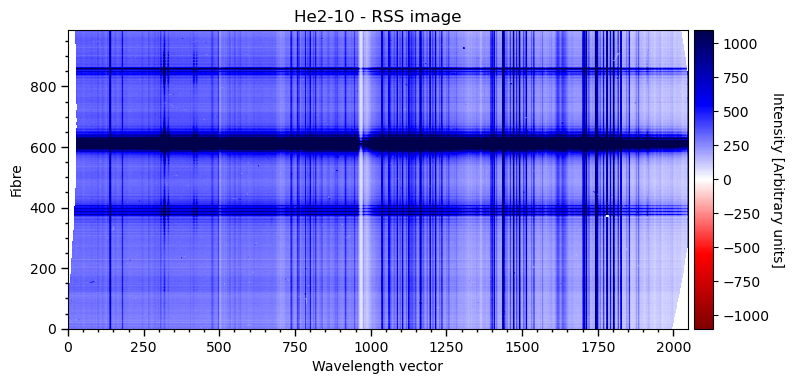

  Found 986 spectra with 2048 wavelengths between 6080.96 and 9305.36 Angstroms.
  This RSS file uses the 385R grating in the red AAOmega arm.
  The KOALA field of view is WIDE: 50.6" x 27.4", with a spaxel size of 1.25" and PA = -0.1º.
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red".


In [5]:
run31_red=process_koala_rss(rss_object_name="run31_red",                         # Name of the object to be created
                            filename=filename,                                   # name of the .fits file to use
                            path = path_to_filename,                             # path to fits file

                            plot_final_rss=True, warnings=True, plot = True, verbose = True        # This plots and verbose everything
                            #plot_final_rss=False, warnings=False, plot = False, verbose = False   # This does not plot or verbose (default)
                            )

## 2. Applying the throughput correction

This is done calling the ThroughputCorrection object correction and applying it to the rss:

throughput_corr = ThroughputCorrection(throughput=throughput, **kwargs)
rss = throughput_corr.apply(rss, **kwargs) 

Using process_koala_rss() is as easy as:

(NOTE that throughput is the object with the throughput calibration we created in the other tutorial, in the example below is # as we are calling it directly from the calibration_night_385R object).


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
> Applying throughput to rss object using Python Throughput object ...


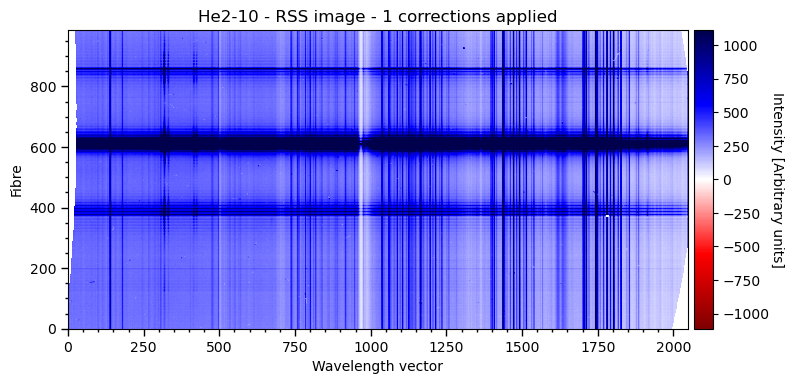


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red".
  Corrections applied: 1 in total:
  - apply_throughput

  All applied corrections are stored in run31_red.intensity !


In [6]:
run31_red=process_koala_rss(rss=run31_red,                                        # rss to use
                            calibration_night = calibration_night_385R,           # Object with the calibration of the night
                            apply_throughput = True,                              # (T)  
                            #throughput=throughput_2D_red,                        # Throughput object, included in calibration_night_385R
                            
                            plot_final_rss=True, warnings=True, plot = True, verbose = True        # This plots and verbose everything
                            #plot_final_rss=False, warnings=False, plot = False, verbose = False   # This does not plot or verbose (default)
                            )

## 3. Correcting CCD defects (C)

Some tasks that check fibre by fibre can fail if nan values are found. That is why it is convenient to run this task to correct these CCD defects replacing the nan for a median value using adjacent values.

The task is rss = clean_nan(rss), which performs a interpolate_image_nonfinite() to both intensity and variance.

Using process_koala_rss(), we just add: correct_ccd_defects = True

In [7]:
run31_red=process_koala_rss(rss=run31_red,                                        # rss to use
                            correct_ccd_defects = True,                           # (C)
                            verbose = True)


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
> Applying nearest neighbour interpolation to remove NaN values ...

> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red".
  Corrections applied: 1 in total:
  - correct_ccd_defects

  All applied corrections are stored in run31_red.intensity !


We can check the corrections done to this rss and the koala history (it is the same now, but in future history will keep parameters used in each step). For corrections done, the items are grouped following the number of times that process_koala_rss() has been run.

In [8]:
print("Corrections done = ",run31_red.koala.corrections_done)
print("KOALA history = ",run31_red.koala.info["history"])

Corrections done =  [['apply_throughput'], ['correct_ccd_defects']]
KOALA history =  ['apply_throughput', 'correct_ccd_defects']


## 4. Small wavelength shift correction (W)

In this step, we apply the small wavelength shift correction using wavelength_shift_correction.apply().

If fix_wavelengths is True but a correction has not been provided, the task will use the rss file to estimate one. In this case, careful with bright objects or with strong nebular lines!


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
> Applying wavelength shift solution to all fibres in object using median offset for skyline ...


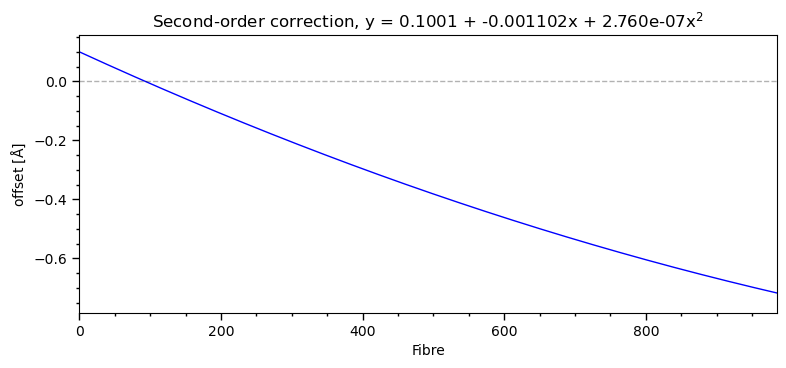

  Polynomic solution: [ 1.00129027e-01 -1.10156218e-03  2.75998633e-07]
  offset_min = -0.717 A ,  offset_max = 0.100 A,  offset_difference = 0.817 A


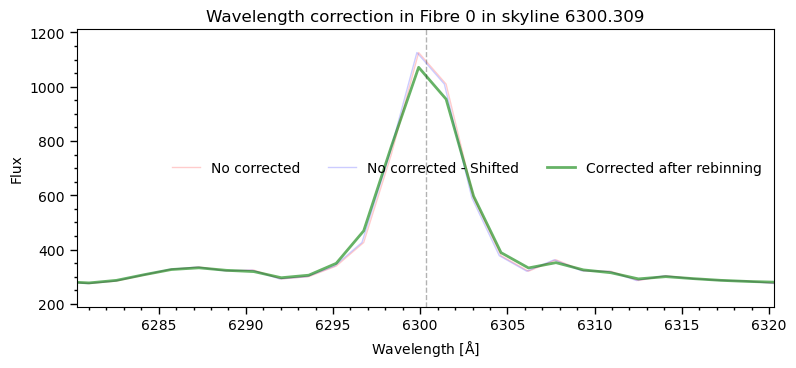

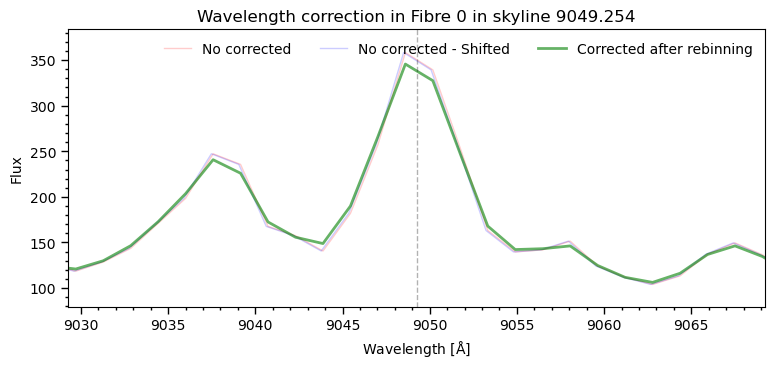

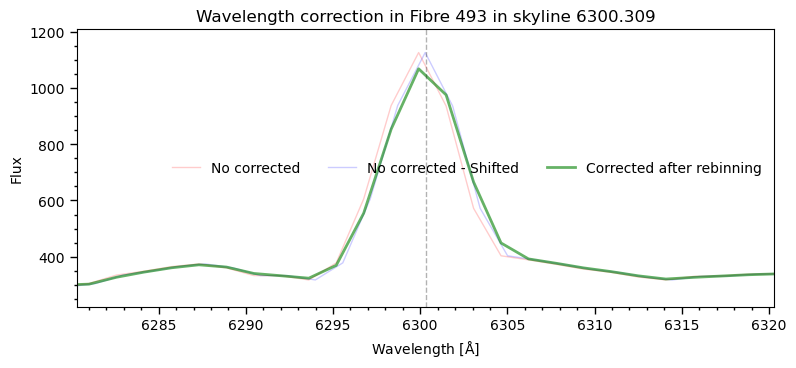

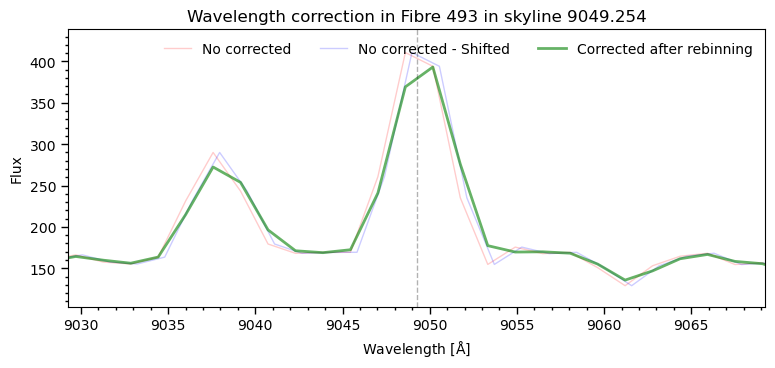

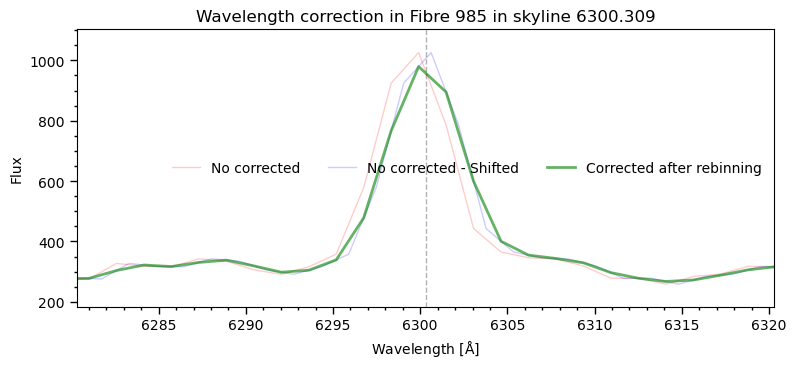

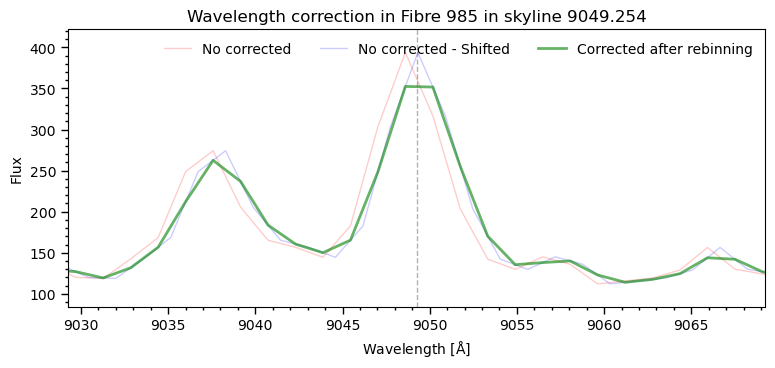


> Small fixing of the wavelength shifts APPLIED!


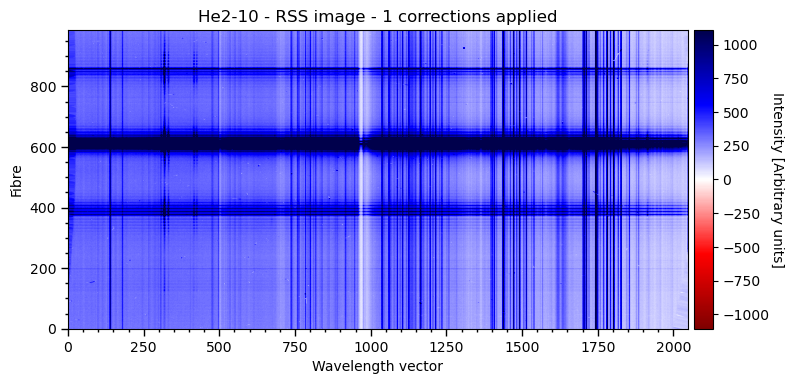


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red".
  Corrections applied: 1 in total:
  - wavelength_shift_correction

  All applied corrections are stored in run31_red.intensity !


In [9]:
run31_red=process_koala_rss(rss=run31_red,                                        # rss to use
                            calibration_night = calibration_night_385R,           # calibration of the night object
                            fix_wavelengths = True,                               # (W)
                            #wavelength_shift_correction = wavelength_shift_correction,   # wavelength shift correction object, included in calibration_night_385R 

                            # Additional options for wavelength_shift_correction.apply():
                            # median_offset_per_skyline_weight = 1,               # Default is 1, median offset for skyline
                                                                                  # If 0, it uses the median of solutions of skylines
                                                                                  # between (0,1): a combination of both
                            # show_fibres_for_wavelength_shifts = None,           # Default, it will then show first (0), middle (423) and last (985) fibre if plot = True
                            # show_skylines_for_wavelength_shifts = None,         # Default, it will then show the first and last skyline used if plot = True.
                            # plot_wavelength_shift_correction_solution = True,   # Default, if True it will plot the wavelenght solution per fibre
                            
                            plot_final_rss=True, warnings=True, plot = True, verbose = True        # This plots and verbose everything
                            #plot_final_rss=False, warnings=False, plot = False, verbose = False   # This does not plot or verbose (default)
                            )

## 5. Atmospheric extinction correction (X) 

Now we apply the atmospheric extinction correction using the corresponding correction object, using the airmass stored in rss.info["airmass"], and the extiction curve at Siding Spring Observatory (included in PyKOALA).

atm_ext_corr = AtmosphericExtCorrection(verbose=verbose)

rss = atm_ext_corr.apply(rss)

In process_koala_rss(), this is as easy as adding correct_for_extinction = True:

In [10]:
run31_red=process_koala_rss(rss=run31_red,                                        # rss object
                            correct_for_extinction = True,                        # (X)
                            verbose = True)


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
[Correction: AtmosphericExtinction] Initialising Atm ext. correction model.
[Correction: AtmosphericExtinction] Loading atmospheric extinction model from:
 /DATA/KOALA/Python/Pablo/koala/src/pykoala/corrections/../input_data/observatory_extinction/ssoextinct.dat
[Correction: AtmosphericExtinction] Applying model-based extinction correction to Data Container (1.14 airmass)

> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red".
  Corrections applied: 1 in total:
  - extinction_correction

  All applied corrections are stored in run31_red.intensity !


In [11]:
# Check corrections done so far
print(run31_red.koala.corrections_done)

[['apply_throughput'], ['correct_ccd_defects'], ['wavelength_shift_correction'], ['extinction_correction']]


## 6. Telluric correction (red arm) (U)

Again, this is just applying the telluric correction we derived before:

rss = telluric_correction.apply(rss, verbose=verbose)

Or, using process_koala_rss():

In [12]:
run31_red=process_koala_rss(rss=run31_red,                                        # rss object
                            calibration_night = calibration_night_385R,           # Object with the calibration of the night
                            apply_telluric_correction=True,                       # (U) Apply the telluric correction
                            #telluric_correction = telluric_correction,           # Telluric correction object, included in calibration_night_385R
                            verbose = True)


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
[Correction: TelluricCorretion] Applying telluric correction to this star...
> Mask included in rss applied to make nan all bad pixels in edges.

> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red".
  Corrections applied: 1 in total:
  - telluric_correction

  All applied corrections are stored in run31_red.intensity !


## 7. Sky subtraction

This is probably the most challenging of all the corrections, as we do not have specific sky fibres in KOALA.

It is recommended to run all the previous steps first, save that file as rss fits file (to avoid applying them again and again), and check sky subtraction carefully in each rss file.

The options for sky subtraction are:

1. Using an external 1D spectrum (that must be provided and will be the same for all fibres),
2. Using an external 2D spectrum (offset sky, perhaps it needs to be scaled, but it will be slightly different for each fibre)
3. Using the same rss file to extract the 1D sky spectrum identifying the source (valid for stars) and subtract to all fibres.
4. Using the same rss file to extract the 1D sky spectrum using the n_sky fibres with lowest integrated value and subtract to all fibres.

Additionally, the 1D spectrum can be applied performing a Gaussian fit to a list of skylines in all fibres. This takes longer but provides the best result so far.

Hence, the options for sky_method are:

- "self": using the same rss
- "selffit": using the same rss and applying a Gaussian fit to a list of skylines in all fibres 
- "1D": Using a provided 1D sky spectrum
- "1Dfit": Using a provided 1D sky spectrum and applying a Gaussian fit to a list of skylines in all fibres
- "2D": Using a provided 2D image as sky spectra
  
Let's first try the default PyKOALA method (sky_method = "self" and estimating background)


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
> Correcting sky using the self method.
  Using Pablo's method for obtaining self sky spectrum ...
[SkyModel]  Creating SkyModel from input Data Container
[SkyModel]  Estimating sky background contribution...
[SkyModel]  Pre-estimating background using all data
[SkyModel]  Applying sigma-clipping mask (n-sigma=5)
[Correction: SkyCorrection] Applying sky substraction
> Mask included in rss applied to make nan all bad pixels in edges.


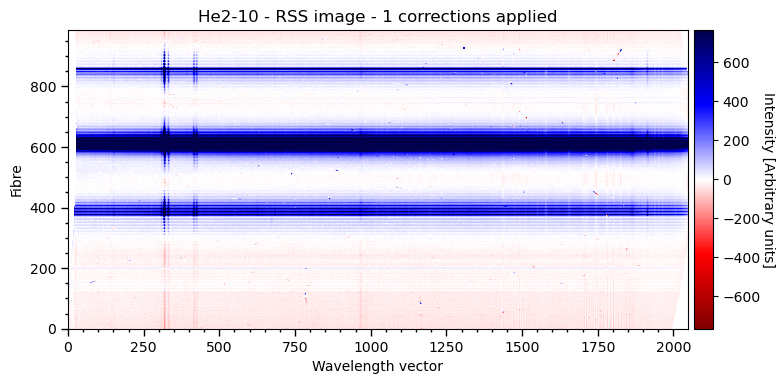


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red_test".
  Corrections applied: 1 in total:
  - sky_correction

  All applied corrections are stored in run31_red_test.intensity !


In [13]:
run31_red_test = process_koala_rss(rss=run31_red,                           # rss object to use
                                   rss_object_name="run31_red_test",        # Name of the object to be created
                                   sky_method = "self",                     # (S) Using the same rss
                                   #skycorrection = None,                   # Sky correction object, if obtained before
                                   #sky_spectrum = None                     # 1D or 2D sky spectrum, if previously obtained
                                   #scale_sky = None                        # If 1D or 2D sky_spectrum provided, scale it by this factor
                                   
                                   plot_final_rss=True, warnings=True, plot = True, verbose = True)

As we see, in this example we get plenty of red fibres: the sky has been overestimated as the object is almost everywhere (these observations should have needed offset sky).

Let's now try the 1D spectrum using n_sky = 25, but we will use for the integrated value of the fibre the [6960,7220] range, which is more or less clean:

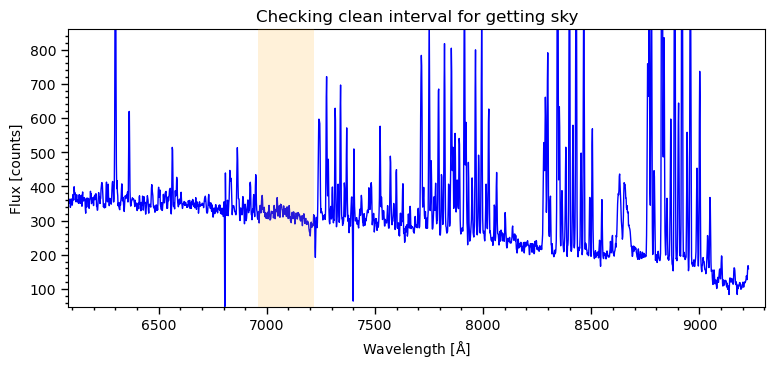

In [14]:
wr = run31_red.wavelength
f0 = run31_red.intensity[0]
plot_plot(wr,f0, axvspan = [[6960,7220]], ptitle="Checking clean interval for getting sky")


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
> Correcting sky using the self method.
> Using 25 fibres with the lowest integrated intensity to get sky spectrum...
> Identifying 25 sky spaxels using the lowest integrated values in the [ 6960 , 7220 ] range ...


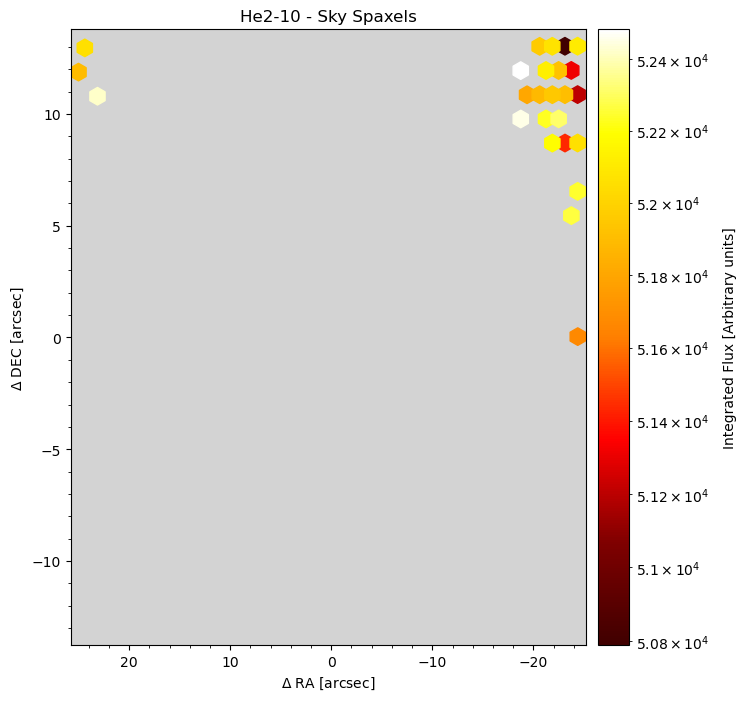

  Combining fibres to create sky spectrum...


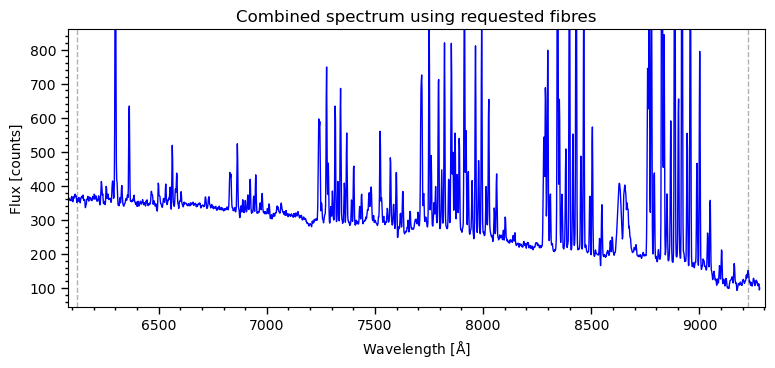

[Correction: SkyCorrection] Applying sky substraction
> Mask included in rss applied to make nan all bad pixels in edges.


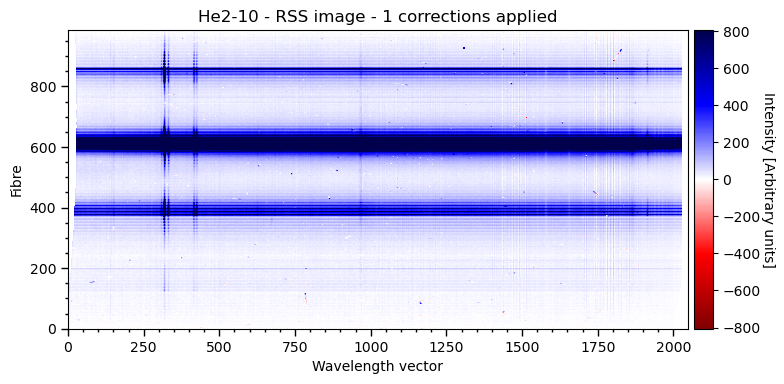


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red_test".
  Corrections applied: 1 in total:
  - sky_correction

  All applied corrections are stored in run31_red_test.intensity !


In [15]:
run31_red_test = process_koala_rss(rss=run31_red,                           # rss object to use
                                   rss_object_name="run31_red_test",        # Name of the object to be created
                                   sky_method = "self",                     # (S) Using the same rss
                                   n_sky = 25,                              # Using the 25 fibres with lowest intensity...          
                                   sky_wave_min=6960,                       # ... between 6960 ..
                                   sky_wave_max=7220,                       # ... and 7220.
                                   #sky_fibres=None                         # We can also provide a list of fibres to use for sky
                                   
                                   plot_final_rss=True, warnings=True, plot = True, verbose = True)

The sky spectrum has been stored in run31_red_test.skymodel.intensity:

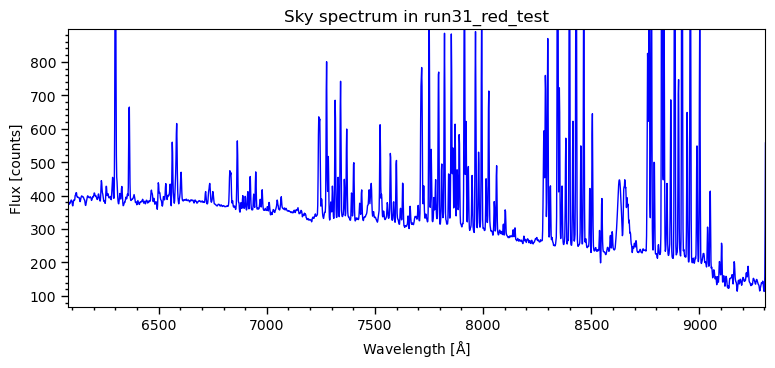

In [15]:
plot_plot(wr, run31_red_test.skymodel.intensity, ptitle="Sky spectrum in run31_red_test")

This result is much better, we still see some sky residuals in the red part, as well as some telluric residua.

Something else that we see is that the red edge has been trimmed: this is because the fibres that we have used to create a sky spectrum do not have valid data in that range. We could try to fix it using the option fix_edges = True:


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
> Correcting sky using the self method.
> Using 25 fibres with the lowest integrated intensity to get sky spectrum...
> Identifying 25 sky spaxels using the lowest integrated values in the [ 6960 , 7220 ] range ...


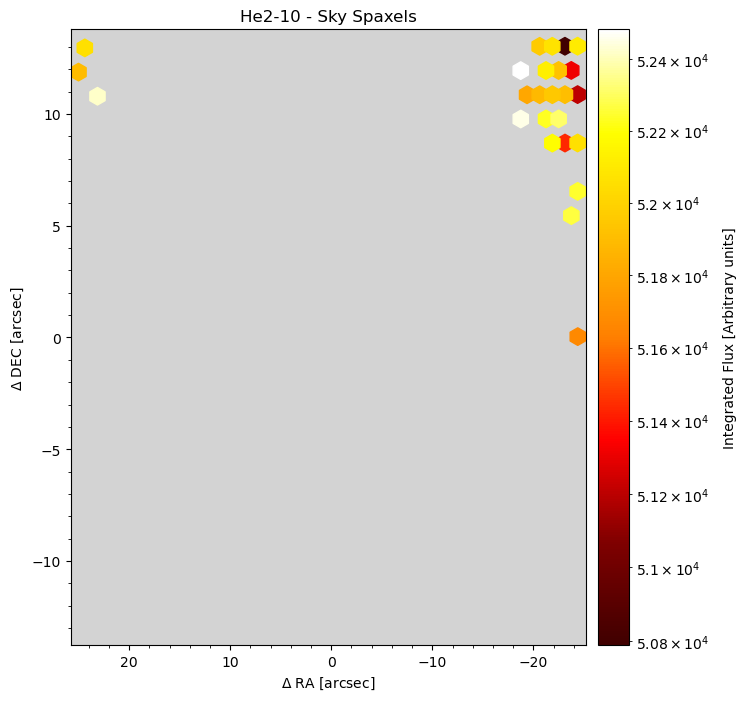

  Combining fibres to create sky spectrum...
  Found nans in edges of sky spectrum... fitting a polynomium in right edge...


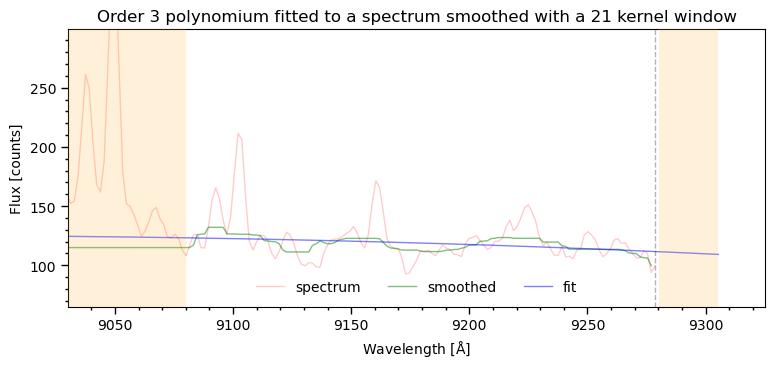

  Left edge of sky spectrum is OK, no need to be fixed


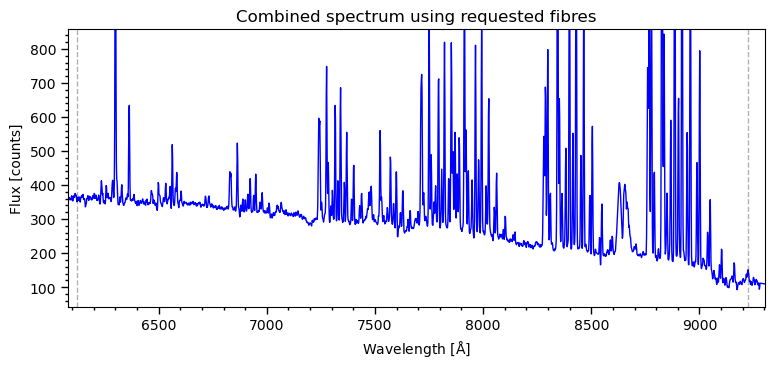

[Correction: SkyCorrection] Applying sky substraction
> Mask included in rss applied to make nan all bad pixels in edges.


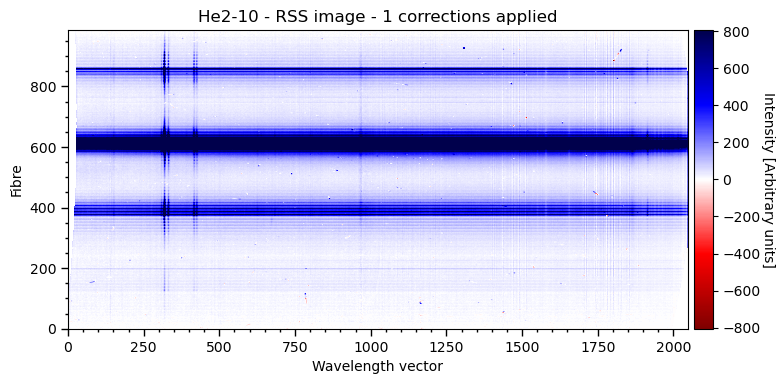


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red_test".
  Corrections applied: 1 in total:
  - sky_correction

  All applied corrections are stored in run31_red_test.intensity !


In [16]:
run31_red_test = process_koala_rss(rss=run31_red,                           # rss object to use
                                   rss_object_name="run31_red_test",        # Name of the object to be created
                                   sky_method = "self",                     # (S) Using the same rss
                                   n_sky = 25,                              # Using the 25 fibres with lowest intensity...          
                                   sky_wave_min=6960,                       # ... between 6960 ..
                                   sky_wave_max=7220,                       # ... and 7220.
                                   fix_edges = True,                        # Use information in the rss to fix the red/blue edges in sky spectrum if needed
                                   #fix_edges_wavelength_continuum = 200,   # (Default) Use 200 A for getting the continuum close to edges
                                   #fix_edges_index_fit=3,                  # (Default) Use a polynomium of degree 3 for continuum in edges
                                   #fix_edges_kernel_fit=21,                # (Default) Smooth the spectrum with a kernel 21 for continuum in edges
                                   
                                   plot_final_rss=True, warnings=True, plot = True, verbose = True)

The other problem with this particular rss is that H-alpha emission from the object has been identified as sky. Although the contribution is small, we can subtract this emission line (once it is identified) using parameter bright_emission_lines_to_substract_in_sky.

For He 2-10, we see that the peak of H-alpha emission is around 6582. 

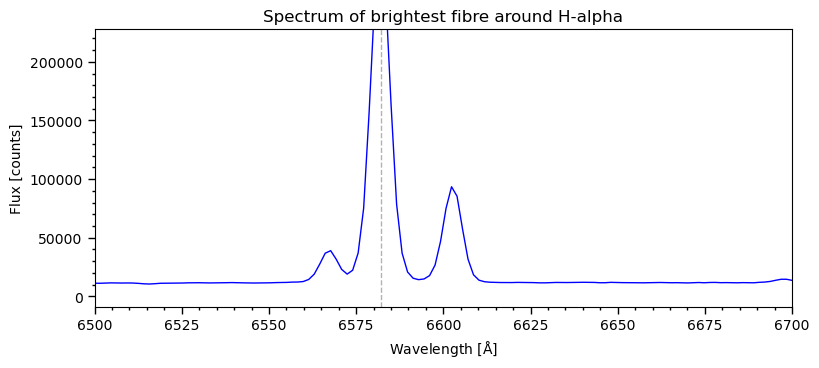

In [17]:
plot_plot(wr,run31_red.intensity[run31_red.koala.integrated_fibre_sorted[-1]], 
          ptitle = "Spectrum of brightest fibre around H-alpha",
          xmin = 6500, xmax = 6700, vlines = [6582])

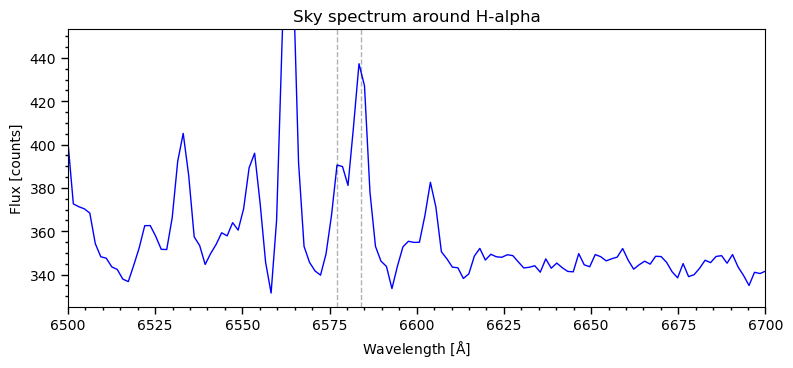

In [19]:
# In the sky spectrum H-alpha is slightly redshifted to 6584, and it is adjacent to skyline 6577
plot_plot(wr,run31_red_test.skymodel.intensity, 
          xmin = 6500, xmax = 6700, vlines = [6577,6584], ptitle= "Sky spectrum around H-alpha")


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
> Correcting sky using the self method.
> Using 25 fibres with the lowest integrated intensity to get sky spectrum...
> Identifying 25 sky spaxels using the lowest integrated values in the [ 6960 , 7220 ] range ...


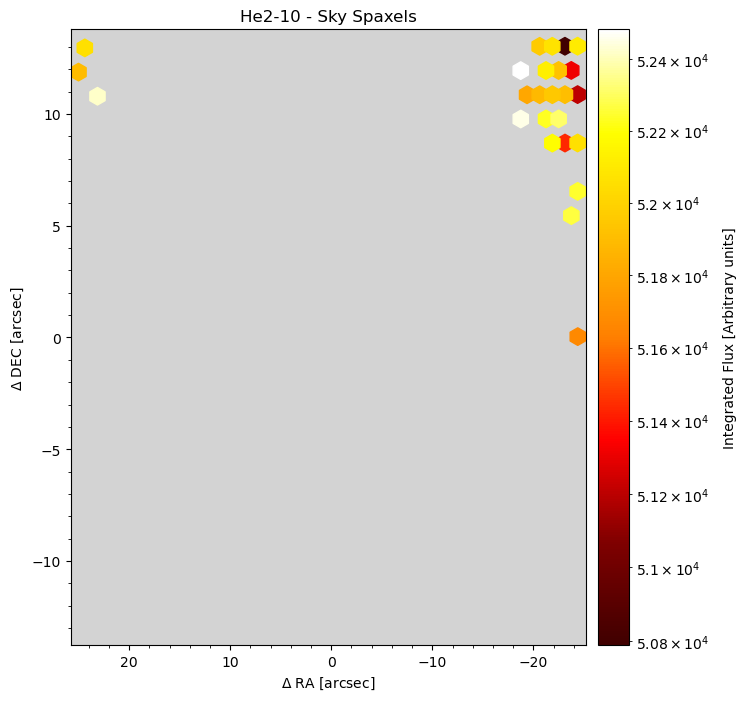

  Combining fibres to create sky spectrum...
> Substracting Ha at around 6584 to sky spectrum...


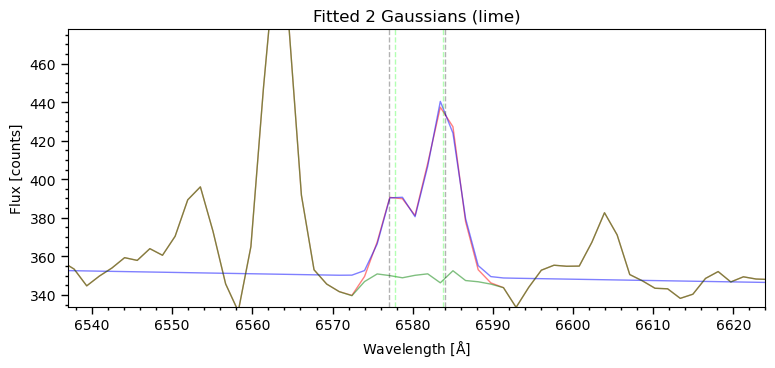

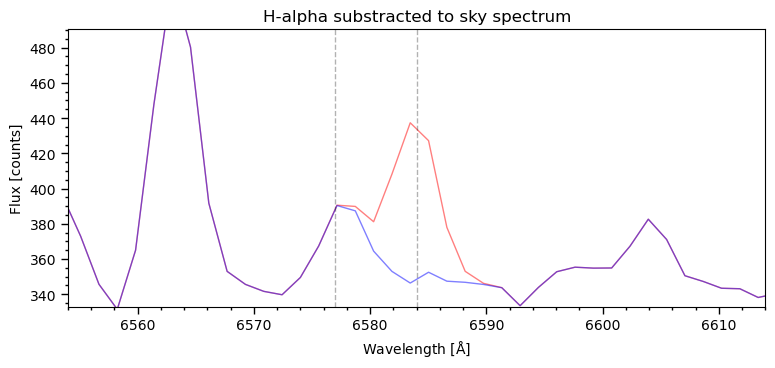

  Found nans in edges of sky spectrum... fitting a polynomium in right edge...


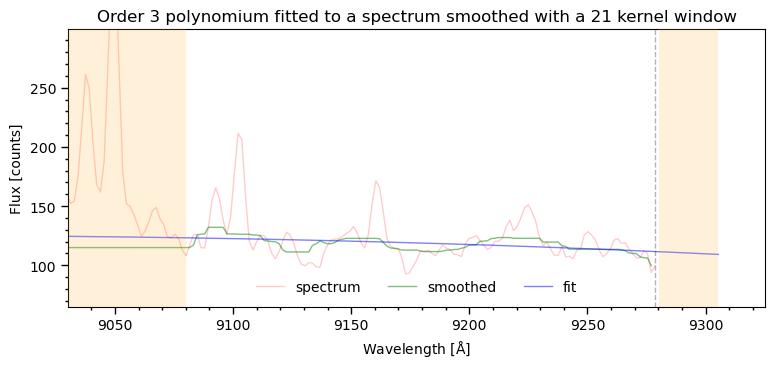

  Left edge of sky spectrum is OK, no need to be fixed


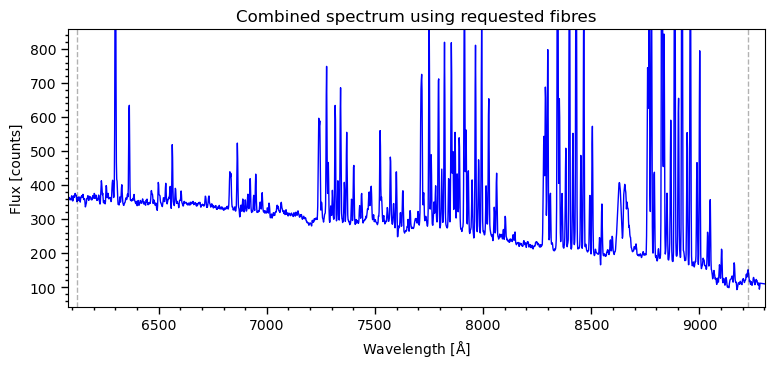

[Correction: SkyCorrection] Applying sky substraction
> Mask included in rss applied to make nan all bad pixels in edges.


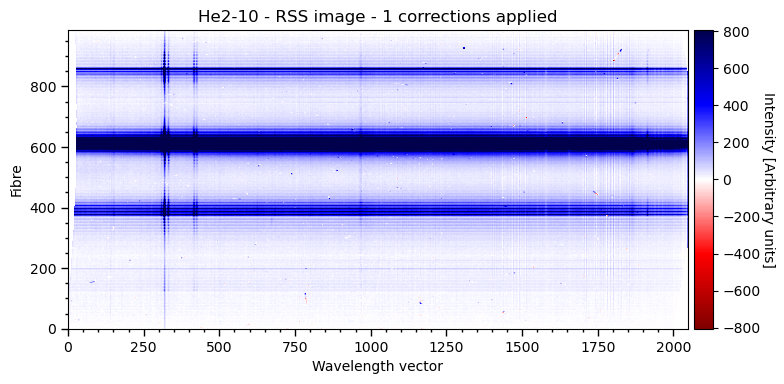


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red_test".
  Corrections applied: 1 in total:
  - sky_correction

  All applied corrections are stored in run31_red_test.intensity !


In [20]:
run31_red_test = process_koala_rss(rss=run31_red,                           # rss object to use
                                   rss_object_name="run31_red_test",        # Name of the object to be created
                                   sky_method = "self",                     # (S) Using the same rss
                                   n_sky = 25,                              # Using the 25 fibres with lowest intensity...          
                                   sky_wave_min=6960,                       # ... between 6960 ..
                                   sky_wave_max=7220,                       # ... and 7220
                                   bright_emission_lines_to_substract_in_sky = [6584],              # List with bright emission lines to substract in sky, typically H-alpha
                                   list_of_skylines_to_fit_near_bright_emission_lines = [[6577]],   # List with lists of adjacent skylines we have to consider close to bright emission lines
                                   fix_edges = True,
                                   
                                   plot_final_rss=True, warnings=True, plot = True, verbose = True)

Still, plenty of residua in the red part of the CCD... so far the best option that we have to improve this is using sky_method = "selffit", this will take a bit (~4-5 minutes for rss file depending on your computer and the number of skylines that we choose to fit).

NOTE: This method has been optimized for the 385R grating, and it will not do much if you try to apply it to other red gratings without providing the list_of_skylines_to_fit.


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
> Correcting sky using the selffit method.
> Using 25 fibres with the lowest integrated intensity to get sky spectrum...
> Identifying 25 sky spaxels using the lowest integrated values in the [ 6960 , 7220 ] range ...


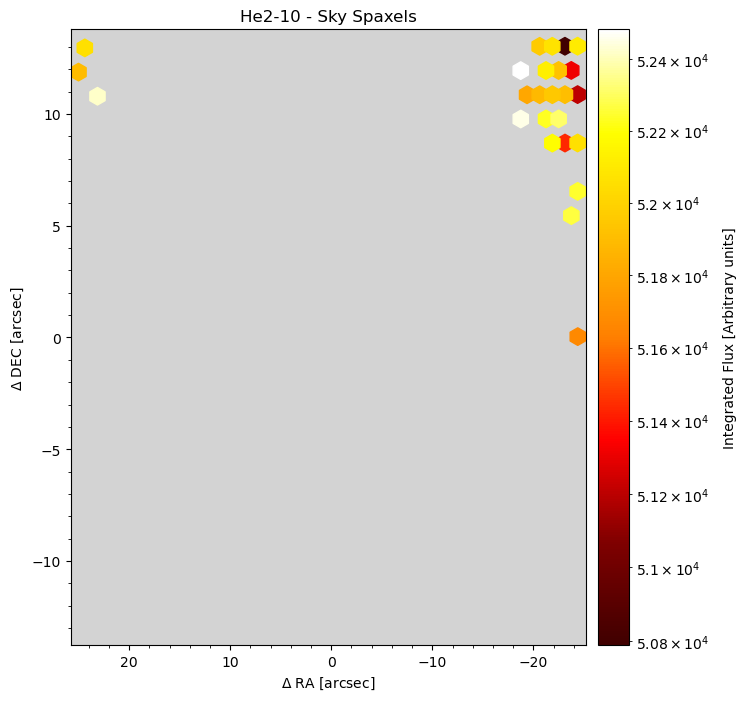

  Combining fibres to create sky spectrum...
> Substracting Ha at around 6584 to sky spectrum...


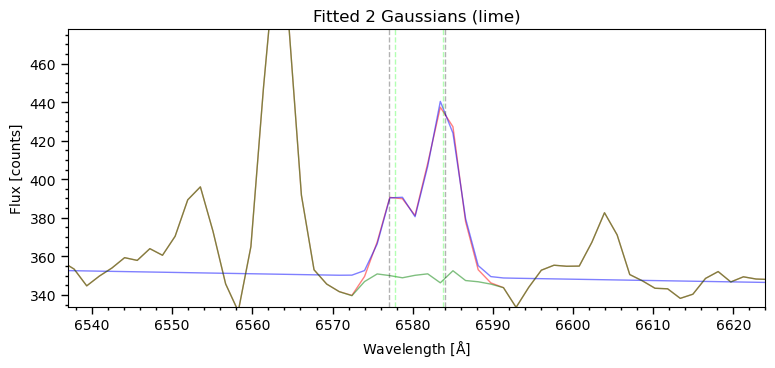

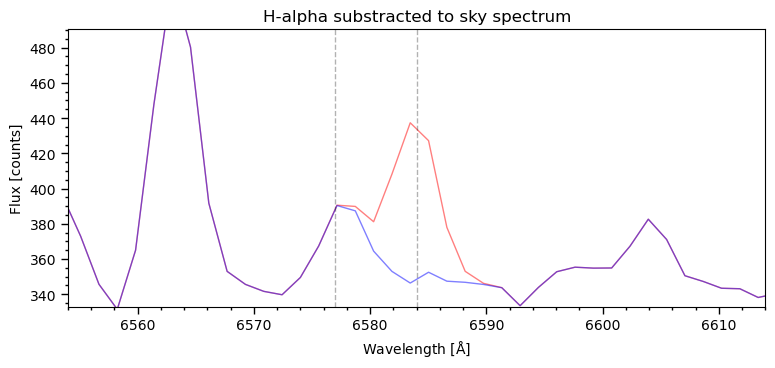

  Found nans in edges of sky spectrum... fitting a polynomium in right edge...


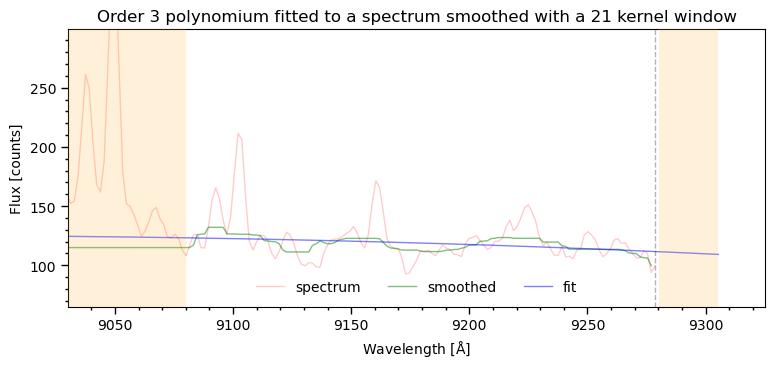

  Left edge of sky spectrum is OK, no need to be fixed


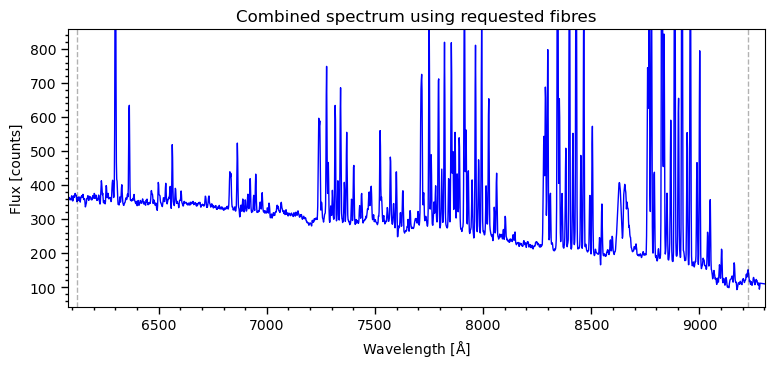


> Modelling sky using Gaussian fits and input sky spectrum.
  - Performing Gaussian fits in input rss...
  Checking fibres completed!

  - Performing Gaussian fits in sky spectrum...
  - Creating individualised sky model per fibre...


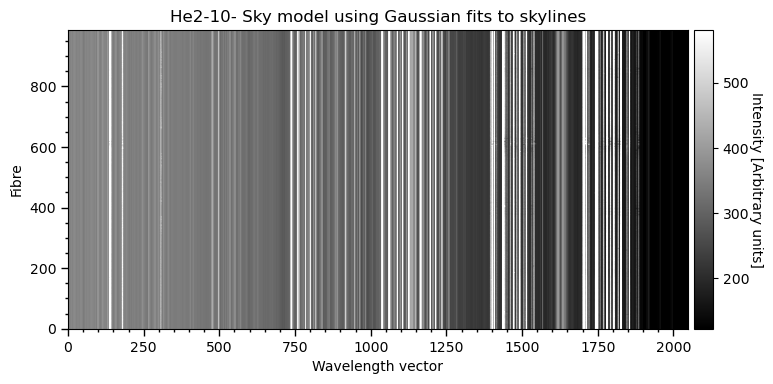

[Correction: SkyCorrection] Applying sky substraction
> Mask included in rss applied to make nan all bad pixels in edges.


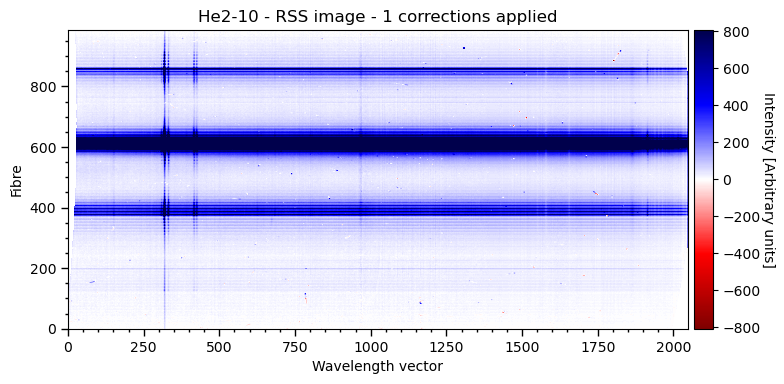


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red_test".
  Corrections applied: 1 in total:
  - sky_correction

  All applied corrections are stored in run31_red_test.intensity !


In [21]:
run31_red_test = process_koala_rss(rss=run31_red,                           # rss object to use
                                   rss_object_name="run31_red_test",        # Name of the object to be created
                                   sky_method = "selffit",                  # (S) Using the same rss and fitting Gaussians to skylines in each fibre
                                   n_sky = 25,                              # Using the 25 fibres with lowest intensity...          
                                   sky_wave_min=6960,                       # ... between 6960 ..
                                   sky_wave_max=7220,                       # ... and 7220
                                   bright_emission_lines_to_substract_in_sky = [6584],              # List with bright emission lines to substract in sky, typically H-alpha
                                   list_of_skylines_to_fit_near_bright_emission_lines = [[6577]],   # List with lists of adjacent skylines we have to consider close to bright emission lines
                                   fix_edges = True,                        # Use information in the rss to fix the red/blue edges in sky spectrum if needed
                                   #list_of_skylines_to_fit = None          # List with the skylines to fit in each fibre, default is all the bright skylines in the 8200-9050 range + 6300.309 & 6363.783

                                   verbose_counter = False,                 # Counter does not work on Jypiter
                                   plot_final_rss=True, warnings=True, plot = True, verbose = True)

The result is much better, still with the telluric residua and some cosmics that we can fix in the next steps.

Perhaps this is a good moment to save the rss as fits file if you have not done it when running process_koala_rss():

In [22]:
koala_rss_to_fits(rss = run31_red_test,                               # RSS object to be saved as fits
                  path = path_to_filename,                            # Path
                  fits_file = "27feb20031red_TCWXUS.fits",            # Fits file to be saved. Note that the letters T C W X U S
                                                                      # indicate the corrections that have been applied to the rss.
                                                                      # This is the default naming if "auto" is given in "fits_file".
                  verbose = True)                                     # Verbose what is done

> Using rss.intensity of given RSS file to create fits file...
  RSS data saved to file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red_TCWXUS.fits"


## 8. Check negative sky (N)

When applying a self sky subtraction, it is likely that some skyfibres are over-corrected. The task correcting_negative_sky() will check all fibres for this problem and correct those that are needed:


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
> Individual correction of fibres with negative sky ... 
  The brightest fibre 610 and faintest fibre 1 will be shown.
  Using fit of order 7 to smooth spectrum with kernel 21 for correcting the negative skies...

- Checking fibre 1 :


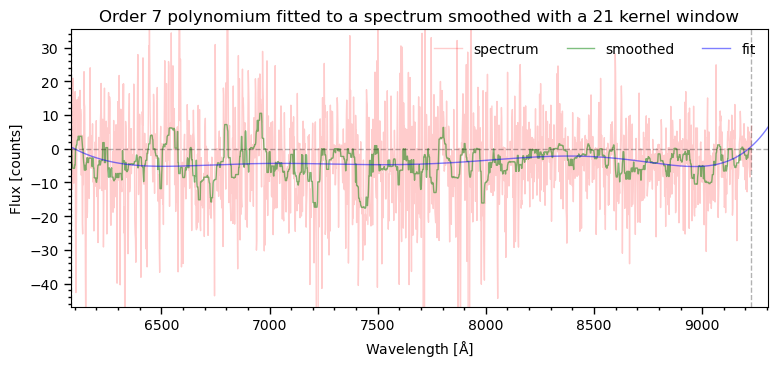

      Using fit to smooth spectrum for correcting the negative sky in fibre 1  ...

- Checking fibre 610 :


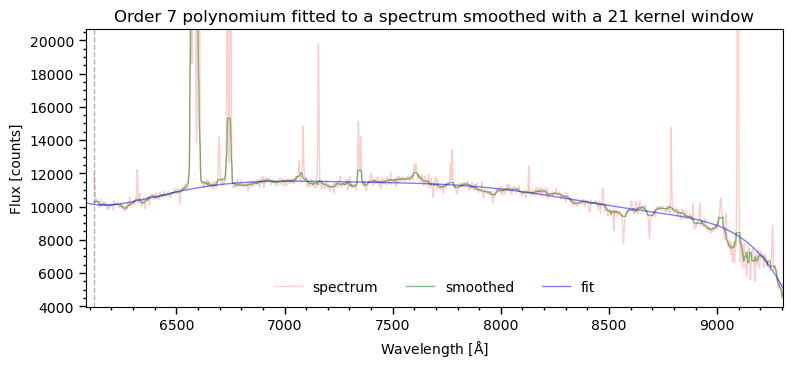

      Fibre 610 does not need to be corrected for negative sky ...
  Corrected 34 fibres for negative sky, 3.45% of fibres.
> Mask included in rss applied to make nan all bad pixels in edges.


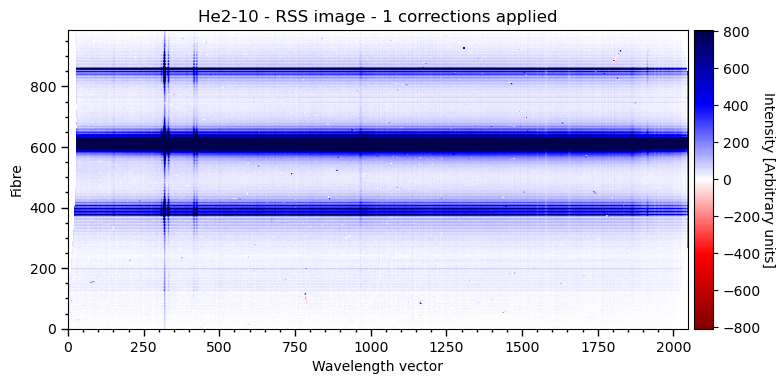


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red".
  Corrections applied: 1 in total:
  - negative_sky_correction

  All applied corrections are stored in run31_red.intensity !


In [34]:
run31_red = copy.deepcopy(run31_red_test)        # Deepcopy after sky subtraction... just in case...

run31_red = process_koala_rss(rss=run31_red,                            # rss object to use
                              rss_object_name="run31_red",              # to be sure the object name is correct after deepcopy
                              correct_negative_sky = True,              # (N) Check fibres for negative sky

                              # These are the parameters for correcting_negative_sky() (and default values):
                              min_percentile_for_negative_sky = 5,      # If percentile 5 of integrated fibre is < 0, it is negative sky and it will be corrected
                              kernel_for_negative_sky = 21,             # Kernel of the smooth spectrum per fibre to remove emission lines
                              order_fit_for_negative_sky = 7,           # Degree of the polynomium to fit smooth spectrum
                              clip_fit_for_negative_sky = 0.8,          # For removing outliers in the fit
                              use_fit_for_negative_sky = True,          # Subtract negative sky with the fit to the spectrum, not the smooth spectrum
                              check_only_sky_fibres = False,            # Check only the sky_fibres, if provided or in rss
                              force_sky_fibres_to_zero=False,           # Forcing integrated spectrum of sky_fibres = 0
                              show_fibres_for_negative_sky = None,      # Show the corrections in these fibres, if plot is True and this is None, it uses the brightest and faintest fibres
                              plot_rss_map_for_negative_sky = False,    # Plot a map with the location of fibres with negative sky
                                   
                              verbose_counter = False,                  # Counter does not work on Jypiter 
                              plot_final_rss=True, warnings=True, plot = True, 
                              verbose = True)

In [35]:
# Check corrections done so far in run31_red:
run31_red.koala.corrections_done

[['apply_throughput'],
 ['correct_ccd_defects'],
 ['wavelength_shift_correction'],
 ['extinction_correction'],
 ['telluric_correction'],
 ['sky_correction'],
 ['negative_sky_correction']]

## 9. Emission line identification (E)

Now it is a good moment to identify the emission lines in our rss, as these might be taken into account for correcting the sky residua.

We use task find_emission_lines_in_koala() for this, that is also included in process_koala_rss():


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
> Combining 6 brightest lines to obtain object spectrum...
> Detecting emission lines in this spectrum...
  Peak of emission is at 6581.8668376283, this should be Ha
  Using line Ha, l_rest = 6562.82, peak at l_obs = 6581.87. 
  v_rad = 870.07 km/s, redshift z = 0.00290223

- Fitting 6385.028134246497 FAILED because out of wave range,


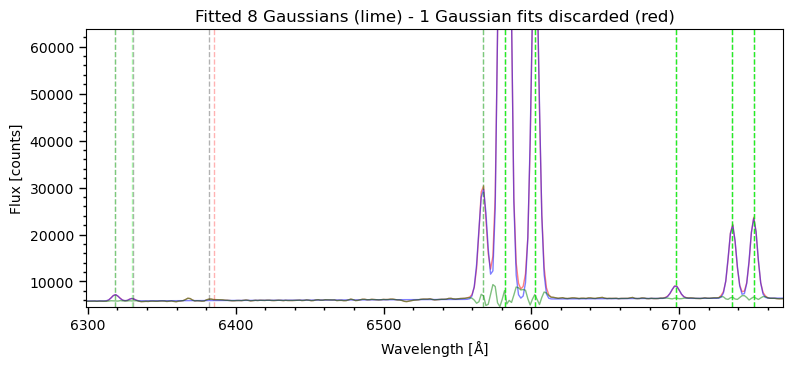

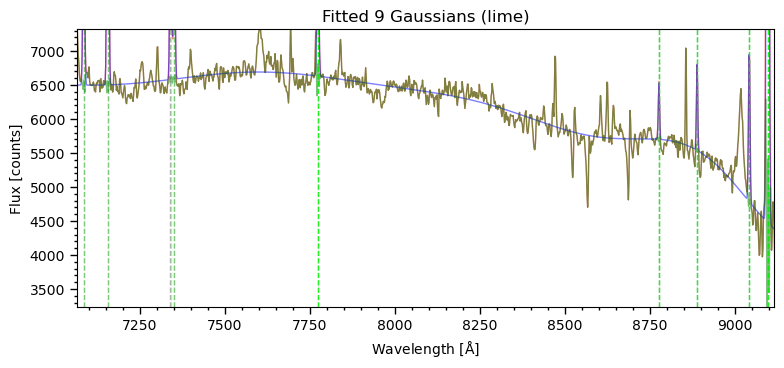

  Identified 17 emission line in this spectrum, with redshift = 0.002910 :
-------------------------------------------------------------------------
   line     ion       fl    Gauss center     peak     sigma         z
-------------------------------------------------------------------------
  6300.30  [OI]     -0.263     6318.62     1345.79    2.371     0.002908
  6312.10  [SIII]   -0.264     6329.84      518.13    1.744     0.002811
  6548.03  [NII]    -0.296     6567.27    23692.97    2.826     0.002938
  6562.82  Ha       -0.298     6581.92   239493.72    2.823     0.002910
  6583.41  [NII]    -0.300     6602.57    77620.68    2.619     0.002910
  6678.15  HeI      -0.313     6697.51     2678.41    2.782     0.002899
  6716.47  [SII]    -0.318     6735.97    15620.18    2.630     0.002903
  6730.85  [SII]    -0.320     6750.44    16981.18    2.584     0.002910
  7065.28  HeI      -0.364     7086.02     3176.63    2.389     0.002936
  7135.78  [ArIII]  -0.374     7156.75     8619.41

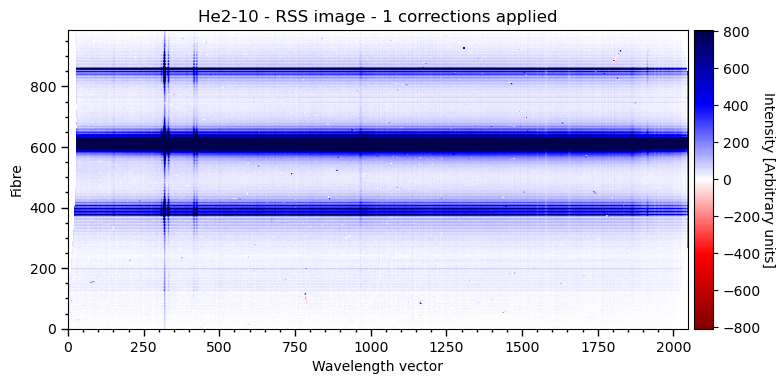


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red".
  Corrections applied: 1 in total:
  - emission_line_identification

  All applied corrections are stored in run31_red.intensity !


In [36]:
run31_red = process_koala_rss(rss=run31_red,              # rss object to use
                              id_el = True,               # (E) Identify emission lines in combined spectrum of rss

                              # These are the parameters find_emission_lines_in_koala():
                              # brightest_line = None,                  # Name of the brightest emission line, "Ha" in red, "Hb" or "[OIII]" in blue, if not given, it uses Ha in red and [OIII] in blue
                              # brightest_line_wavelength = None,       # OBSERVED wavelength of the brightest line, if not given it will be estimated automatically
                              # brightest_fibres_to_combine = 10,       # Number of fibres to combine to create a spectrum of the object, default are the 10 brightest fibres
                              
                              plot_final_rss=True, warnings=True, plot = True, verbose = True) 

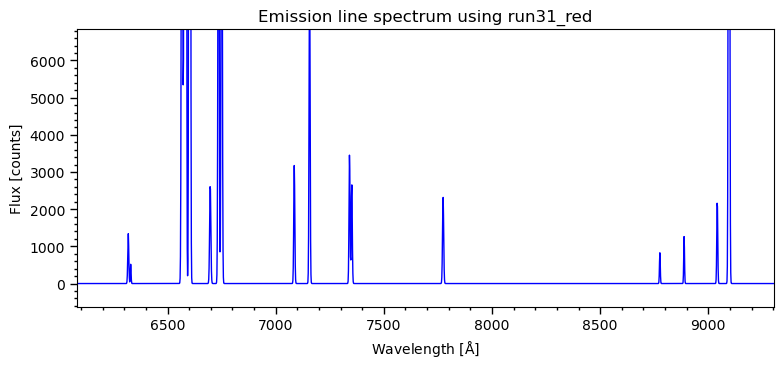

In [37]:
# The emission line spectrum has been recorded in koala.emission_lines_gauss_spectrum
plot_plot(wr,run31_red.koala.emission_lines_gauss_spectrum, ptitle = "Emission line spectrum using run31_red")

In [38]:
# Similarly, a dictionary with the emission lines detected is included in koala.redshifted_emission_lines_detected_dictionary:
run31_red.koala.redshifted_emission_lines_detected_dictionary

{6300.3: {'ion': '[OI]',
  'fl': -0.263,
  'gauss': [6318.623970294089, 1345.791646524714, 2.371335490059123]},
 6312.1: {'ion': '[SIII]',
  'fl': -0.264,
  'gauss': [6329.8413838291035, 518.1292411921846, 1.7436530211883294]},
 6548.03: {'ion': '[NII]',
  'fl': -0.296,
  'gauss': [6567.26966119366, 23692.9665745724, 2.826100234287539]},
 6562.82: {'ion': 'Ha',
  'fl': -0.298,
  'gauss': [6581.919306185574, 239493.72486934546, 2.8231571025831794]},
 6583.41: {'ion': '[NII]',
  'fl': -0.3,
  'gauss': [6602.5688754033, 77620.68410894432, 2.6193347980968116]},
 6678.15: {'ion': 'HeI',
  'fl': -0.313,
  'gauss': [6697.513244066691, 2678.411758038314, 2.7820389464478223]},
 6716.47: {'ion': '[SII]',
  'fl': -0.318,
  'gauss': [6735.970751139047, 15620.183618282197, 2.630443663689283]},
 6730.85: {'ion': '[SII]',
  'fl': -0.32,
  'gauss': [6750.439823464429, 16981.18146593862, 2.584087948973488]},
 7065.28: {'ion': 'HeI',
  'fl': -0.364,
  'gauss': [7086.0248940235215, 3176.6267543052927, 2.

## 10. Cleaning sky residuals (R)

This step is typically only needed for the red grating.

The specific task is clean_telluric_residuals(). It has plenty of parameters, some of them are still under testing.

If any clean_telluric_residuals() or clean_extreme_negatives() or kill_cosmics() is choosen, first we need a continuum model of the RSS (to remove emission lines) that is obtained using the task rss_continuum_image(). This takes a little bit (~1 minute) but it is later saved in koala.continuum_model_after_sky_correction.

In this example, let's correct only the residua of the big telluric absorption at ~7600. As we are plotting, we will also get an image with the comparison before / after correction and the correction.


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 
> Creating a continuum image of this rss...
  Checking fibres completed!                             


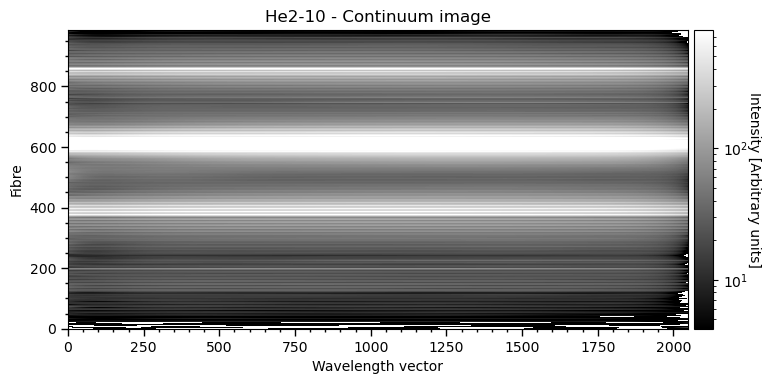

> Cleaning the residuals of this rss in the interval [7590, 7640]
  checking Gaussian fits in fibres with min_value_per_wave_for_fitting > 50 ...
  Checking fibres completed!



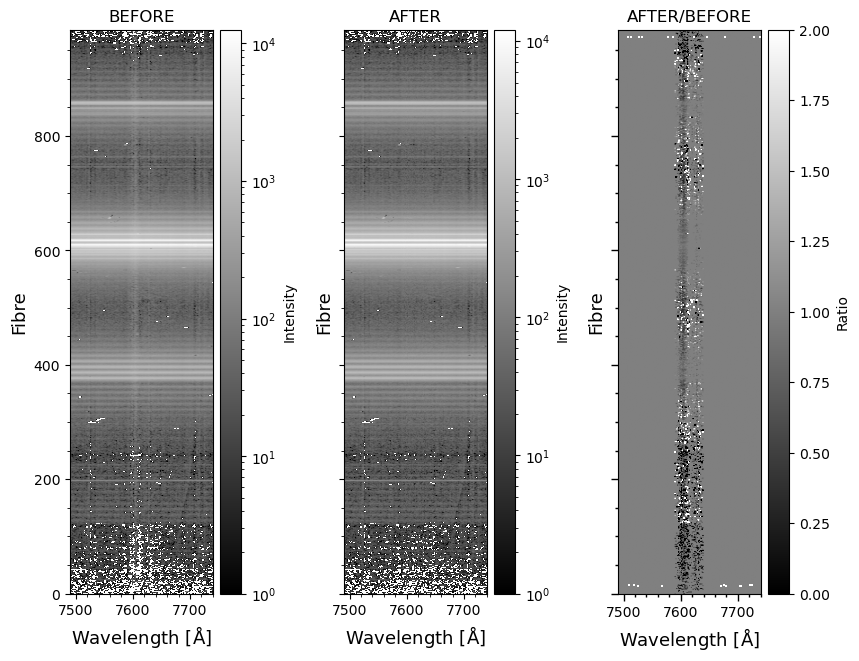

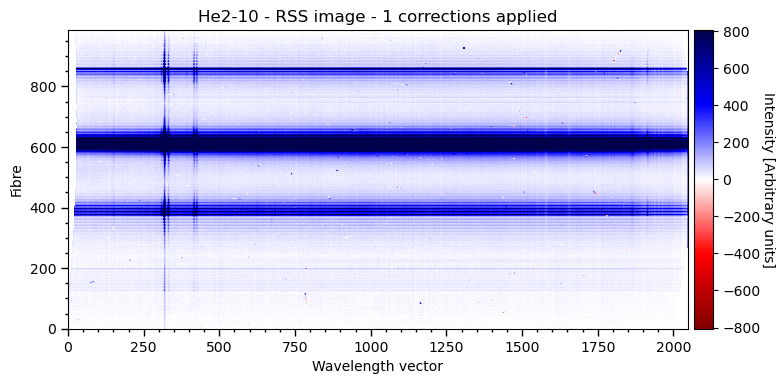


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red".
  Corrections applied: 1 in total:
  - big_telluric_residua_correction

  All applied corrections are stored in run31_red.intensity !


In [39]:
run31_red = process_koala_rss(rss=run31_red,                # rss object to use
                              #continuum_model_after_sky_correction = continuum_model_after_sky_correction   # In case we have it already
                              big_telluric_residua_correction = True,               # (R) Fix residua of big telluric absorption at 7600 A
                              telluric_residua_at_6860_correction = False,          # (R) Fix residua of the telluric absorption at 6860 A
                              
                              # These are main parameters for clean_telluric_residuals():
                              # Many and need to be checked...
                              
                              verbose_counter = False,                                           # Counter does not work on Jypiter
                              plot_final_rss=True, warnings=False, plot = True, verbose = True)  # Note warnings = False here

## 11. Cleaning extreme negative values (R)

We use the task clean_extreme_negatives() for correcting extreme negatives. Again, this is included in process_koala_rss():

Note that the corrections to extreme negatives are typically found in the sky fibres and near the edges.


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 

> Correcting the extreme negatives in all fibres, making any pixel below
  np.nanpercentile(intensity_corrected,  0.05 ) =  -130.04
  to have the median value of the fibre...
  Checking fibres completed!



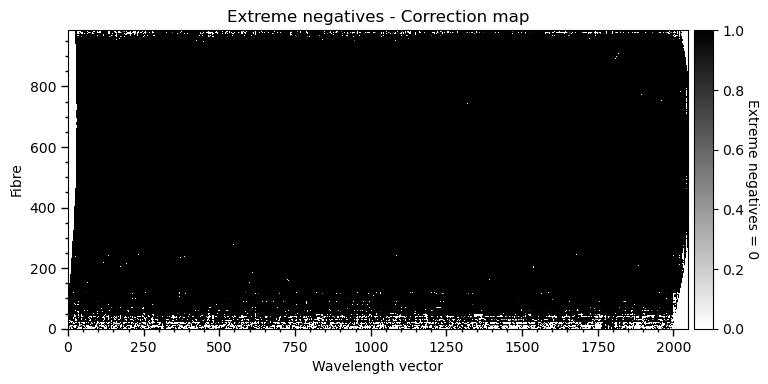

> Mask included in rss applied to make nan all bad pixels in edges.


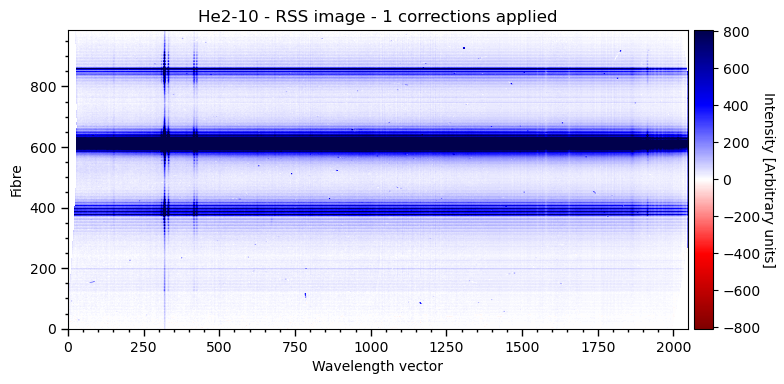


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red".
  Corrections applied: 1 in total:
  - correct_extreme_negatives

  All applied corrections are stored in run31_red.intensity !


In [40]:
run31_red = run31_red = process_koala_rss(rss=run31_red,                                 # rss object to use
                                          correct_extreme_negatives = True,              # (R) Correct for extreme negatives

                                          # These are main parameters for clean_extreme_negatives() and default values:
                                          # percentile_min_for_extreme_negatives = 0.05,      # Percentile below which extreme negative will be corrected
                                          # fibres_to_fix = None                              # It is possible to select only few fibres to check, e.g., sky_fibres 
                                          # continuum = continuum_model_after_sky_correction  # We already have this in the rss from the previous step
                              
                                          verbose_counter = False,                             # Counter does not work on Jypiter
                                          plot_final_rss=True, warnings=True, plot = True, verbose = True) 

## 12. Cleaning bright cosmic rays not deleted by 2dFdr (R)

Finally, we can further eliminate some bright cosmic rays that has not been deleted by 2dFdr using the task kill_cosmics(), also included in process_koala_rss(). The task is clever enough for only eliminating few cosmics per fibre and wavelength, hence reducing the risk of removing real emission lines, but still check in every case.

If you want to be absolutely sure that this is working well, keep only_plot_cosmics_cleaned = False and warnings = True.


> Processing file /DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits as requested... 

> Finding and killing cosmics in all fibres...


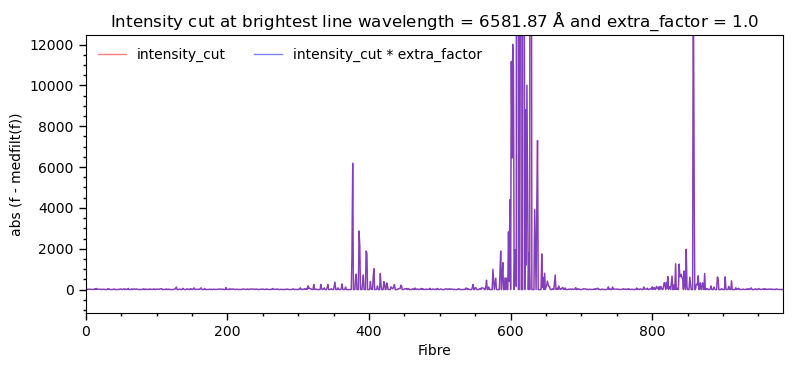

  Skipping 6572.4157 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6573.9909 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6575.5661 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6577.1413 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6578.7165 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6580.2917 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6581.8668 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6583.4420 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6585.0172 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6586.5924 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6588.1676 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6589.7427 as it is adjacent to brightest line wavelenght 6581.8668
  Skipping 6591.3179 as it is adjacent to brightest line wavelen

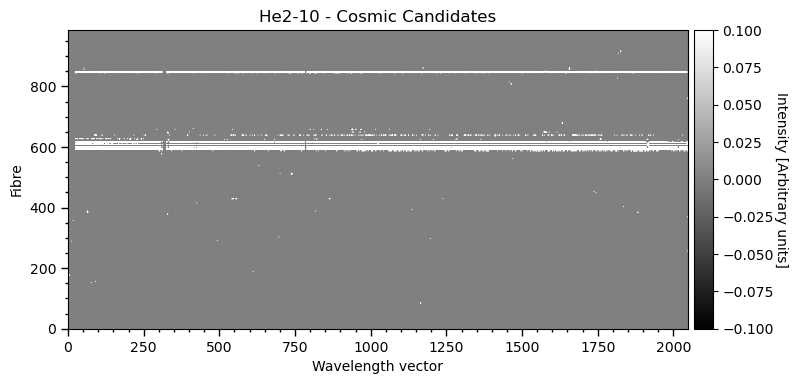


  Total number of cosmic candidates found = 14753, correcting only if < 12 per wavelength ...
  WARNING! Fibre 429 has 15 cosmics found, this is larger than 12 and hence is NOT corrected!
  WARNING! Fibre 587 has 309 cosmics found, this is larger than 12 and hence is NOT corrected!
  WARNING! Fibre 593 has 1995 cosmics found, this is larger than 12 and hence is NOT corrected!
  WARNING! Fibre 595 has 1991 cosmics found, this is larger than 12 and hence is NOT corrected!
  WARNING! Fibre 600 has 1964 cosmics found, this is larger than 12 and hence is NOT corrected!
  WARNING! Fibre 608 has 1972 cosmics found, this is larger than 12 and hence is NOT corrected!
  WARNING! Fibre 611 has 92 cosmics found, this is larger than 12 and hence is NOT corrected!
  WARNING! Fibre 615 has 1899 cosmics found, this is larger than 12 and hence is NOT corrected!
  WARNING! Fibre 617 has 1858 cosmics found, this is larger than 12 and hence is NOT corrected!
  WARNING! Fibre 625 has 30 cosmics found, thi

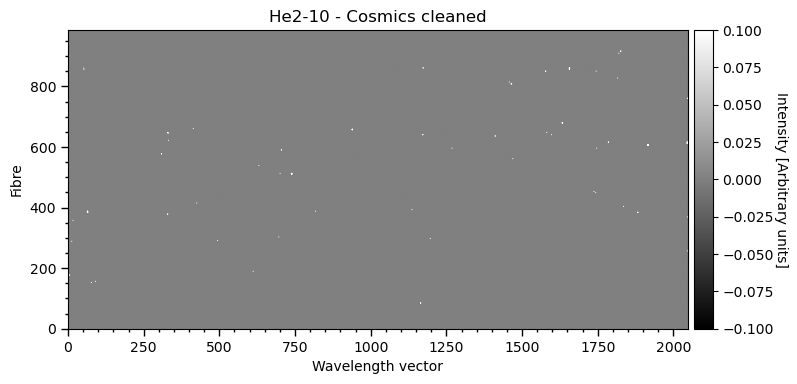

  Total number of cosmics cleaned =  110
> Mask included in rss applied to make nan all bad pixels in edges.


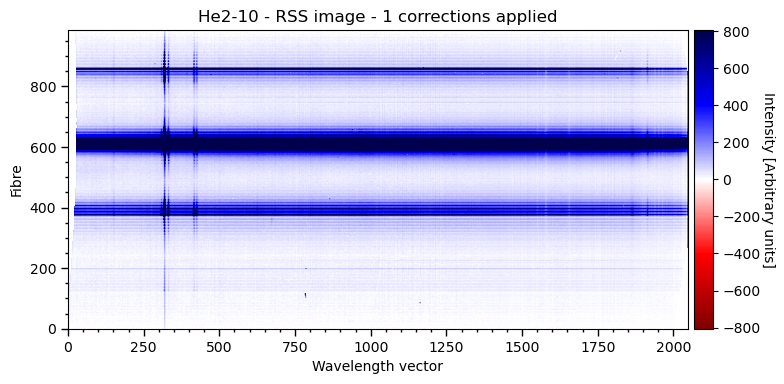


> Summary of processing rss file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red.fits" :
  Name of the observation = "He2-10",   Name of this Python RSS object = "run31_red".
  Corrections applied: 1 in total:
  - clean_cosmics

  All applied corrections are stored in run31_red.intensity !


In [33]:
run31_red = process_koala_rss(rss=run31_red,                              # rss object to use
                              clean_cosmics = True,                       # (R) Clean cosmics

                              # These are the parameters for kill_cosmics() and default values:
                              # brightest_line_wavelength = None,         # Needed in kill_cosmics() but not in process_koala_rss(), as it uses the results in rss object or find it itself.
                              # width_bl = 20,                            # Width in A of the bright emission line. 20 is the default value
                              # kernel_median_cosmics = 5,                # Width of the median filter
                              # cosmic_higher_than = 100,                 # 100x the intensity of the peak at brightest_line_wavelength to be considered as cosmics (default)
                                                                          # NOTE: if you decrease this value, you'll need to increase max_number_of_cosmics_per_fibre
                                                                          #       as you'll get more cosmics! Also perhaps dissable warnings with warnings = False
                              # extra_factor = 1,                         # Multiply cosmic_higher_than for this extra factor (default)
                              # max_number_of_cosmics_per_fibre = 12,     # Max number of cosmics to clean per fibre or wavelength, if more than this it does not correct anything.
                              # fibre_to_fix = None,                      # Only apply this correction in these fibres, default is None, meaning all fibres
                              # only_plot_cosmics_cleaned = False         # The only plot that this task will provide, default is False, but use True for minimizing plotting
                              # continuum = continuum_model_after_sky_correction,  # Already obtained and stored in rss, but can be given here too.
                              
                              verbose_counter = False,                             # Counter does not work on Jypiter
                              plot_final_rss=True, warnings=True, plot = True, verbose = True)   

## 13. Save your processed RSS data in fits files.

Finally, we can save the final, clean RSS file. We can use task koala_rss_to_fits() or the very same process_koala_rss():

In [57]:
koala_rss_to_fits(rss = run31_red,                                    # RSS object to be saved as fits
                  fits_file = "clean",                                # It will add "clean" at the end of the original file
                  verbose = True)                                     # Verbose what is done

> Using rss.intensity of given RSS file to create fits file...
  RSS data saved to file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20031red_clean.fits"


# Do everything together using process_koala_rss()

We can run everything together using process_koala_rss(), as shown in the example below for run32. 

As it is for the same object that for run31, we should expect parameters to be basically the same for run32. 

In this example, the only thing that we have added is max_number_of_cosmics_per_fibre = 15 instead of 12, and only_plot_cosmics_cleaned = True.

Remember using warnings = False, plot = False and verbose = False to make it faster! In this example we disable warnings.


> Converting KOALA+AAOmega RSS file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20032red.fits" to a koala RSS object...


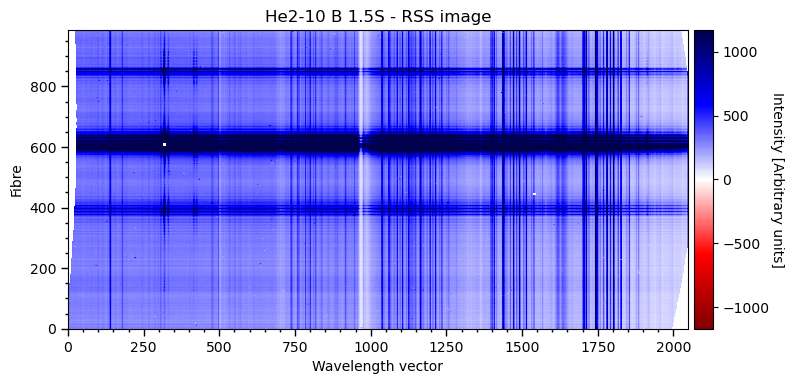

  Found 986 spectra with 2048 wavelengths between 6080.96 and 9305.36 Angstroms.
  This RSS file uses the 385R grating in the red AAOmega arm.
  The KOALA field of view is WIDE: 50.6" x 27.4", with a spaxel size of 1.25" and PA = -0.1º.
  Name of the observation = "He2-10 B 1.5S",   Name of this Python RSS object = "run32_red".

> Processing file 27feb20032red.fits as requested... 
> Applying throughput to rss object using Python Throughput object ...
> Applying nearest neighbour interpolation to remove NaN values ...
> Applying wavelength shift solution to all fibres in object using median offset for skyline ...


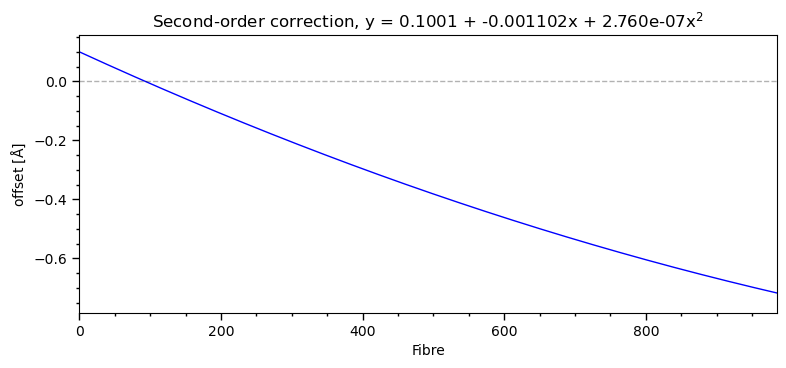

  Polynomic solution: [ 1.00129027e-01 -1.10156218e-03  2.75998633e-07]
  offset_min = -0.717 A ,  offset_max = 0.100 A,  offset_difference = 0.817 A


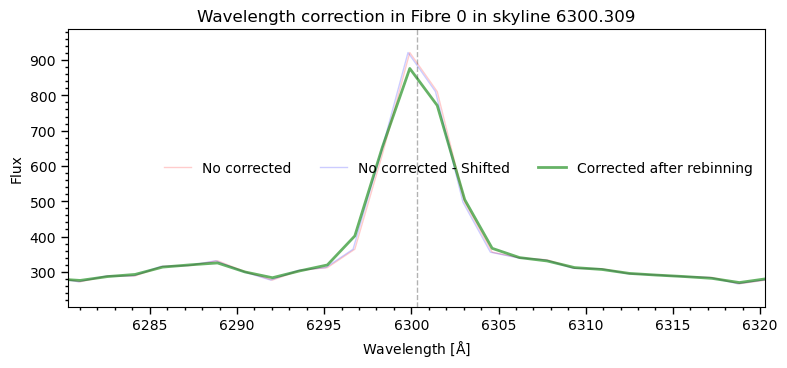

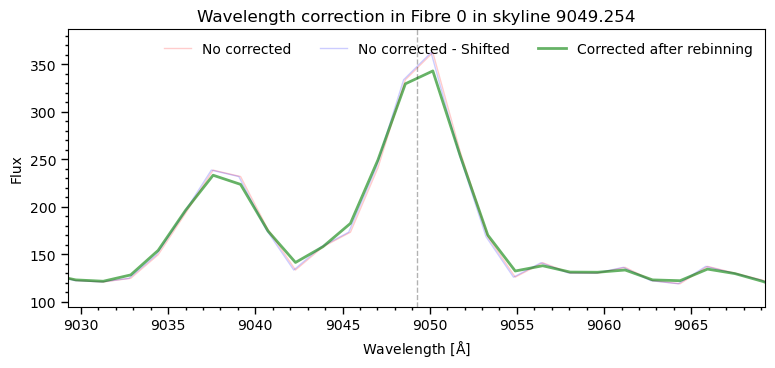

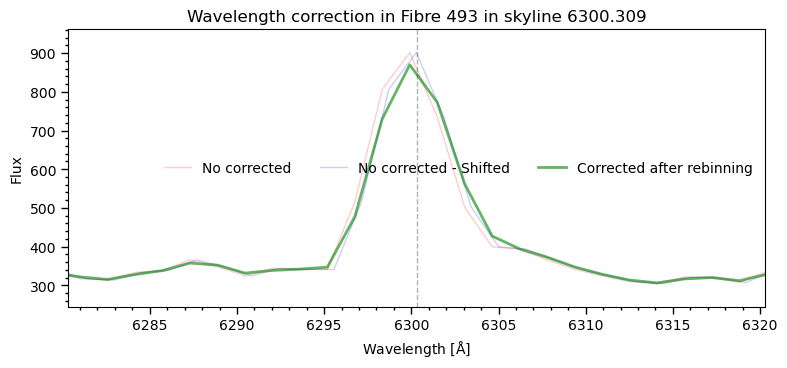

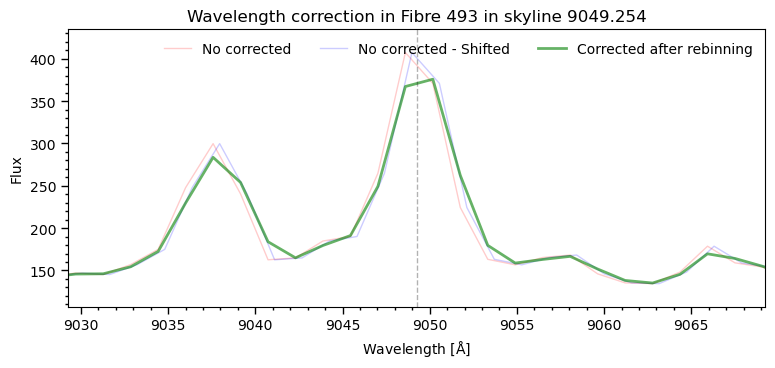

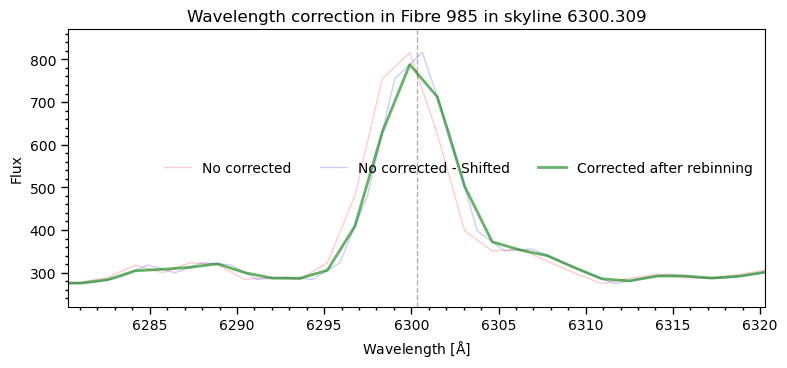

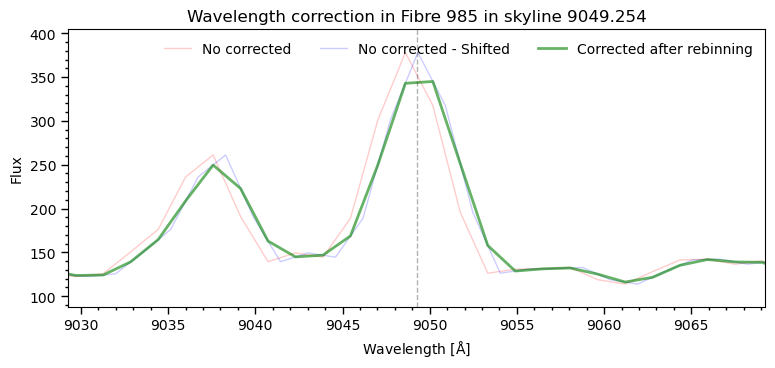


> Small fixing of the wavelength shifts APPLIED!
[Correction: AtmosphericExtinction] Initialising Atm ext. correction model.
[Correction: AtmosphericExtinction] Loading atmospheric extinction model from:
 /DATA/KOALA/Python/Pablo/koala/src/pykoala/corrections/../input_data/observatory_extinction/ssoextinct.dat
[Correction: AtmosphericExtinction] Applying model-based extinction correction to Data Container (1.10 airmass)
[Correction: TelluricCorretion] Applying telluric correction to this star...
> Correcting sky using the selffit method.
> Using 25 fibres with the lowest integrated intensity to get sky spectrum...
> Identifying 25 sky spaxels using the lowest integrated values in the [ 6960 , 7220 ] range ...


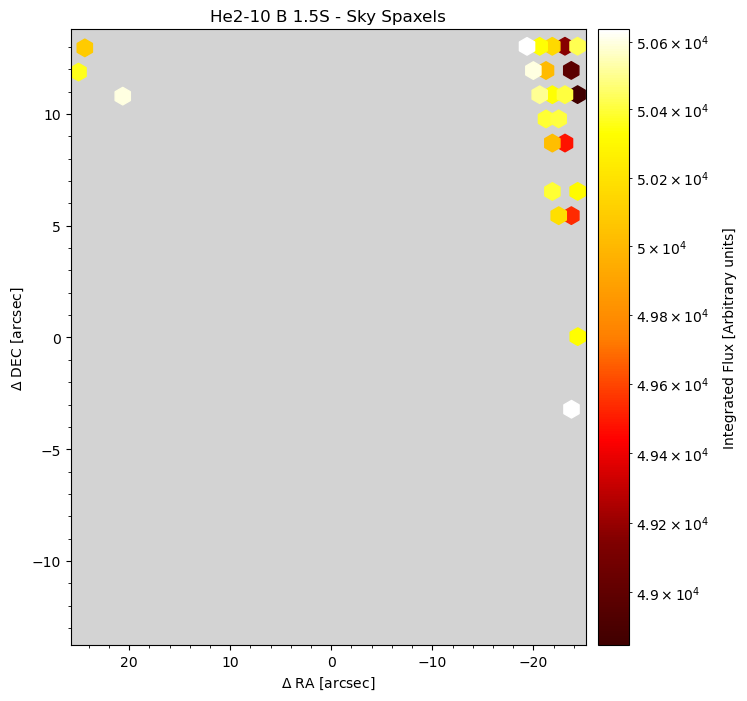

  Combining fibres to create sky spectrum...
> Substracting Ha at around 6584 to sky spectrum...


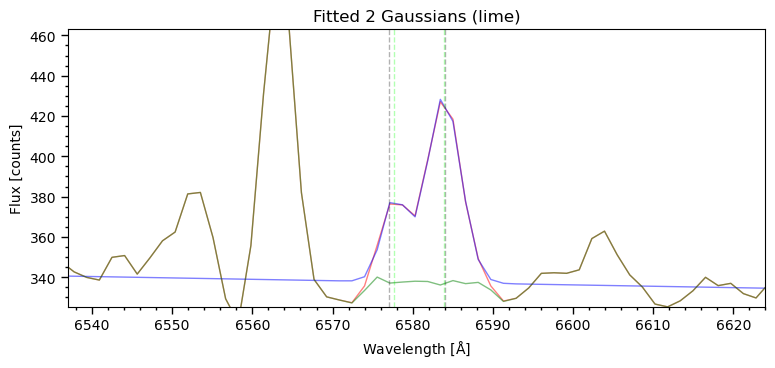

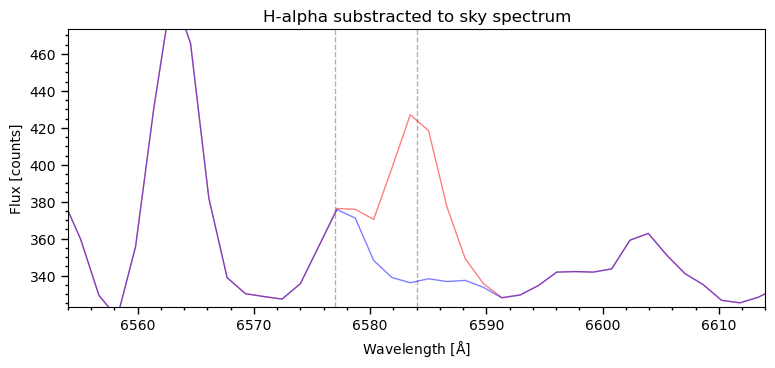

  Found nans in edges of sky spectrum... fitting a polynomium in right edge...


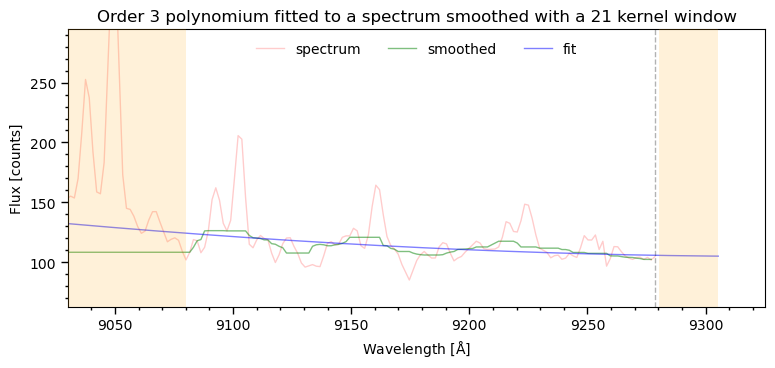

  Left edge of sky spectrum is OK, no need to be fixed


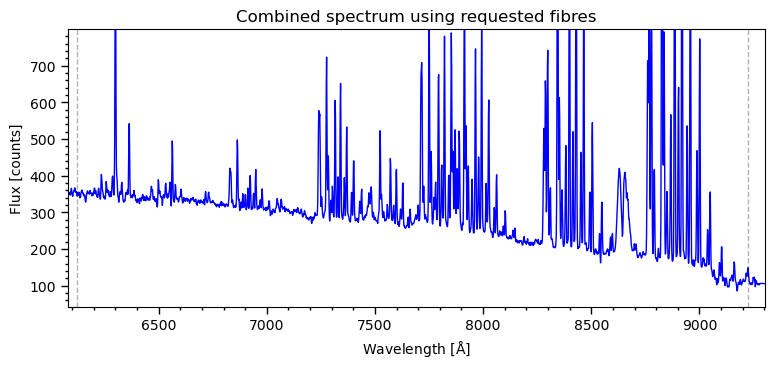


> Modelling sky using Gaussian fits and input sky spectrum.
  - Performing Gaussian fits in input rss...
  Checking fibres completed!

  - Performing Gaussian fits in sky spectrum...
  - Creating individualised sky model per fibre...


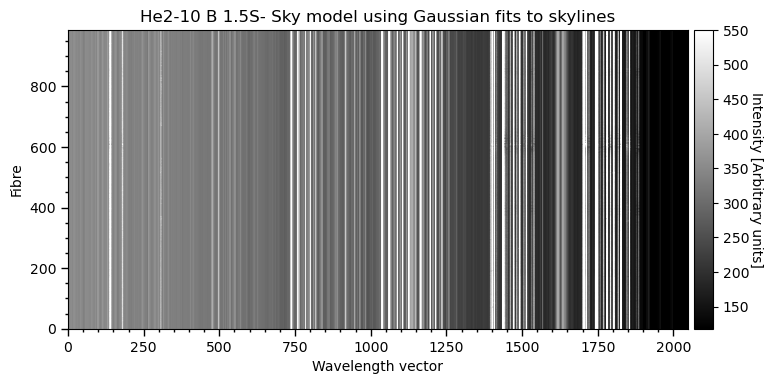

[Correction: SkyCorrection] Applying sky substraction
> Individual correction of fibres with negative sky ... 
  The brightest fibre 608 and faintest fibre 10 will be shown.
  Using fit of order 7 to smooth spectrum with kernel 21 for correcting the negative skies...

- Checking fibre 10 :


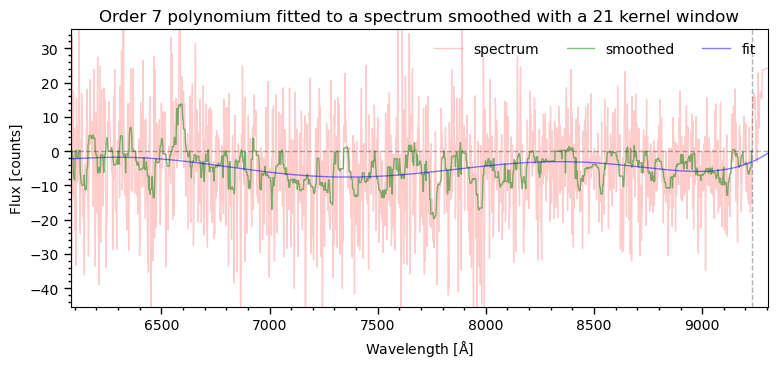

      Using fit to smooth spectrum for correcting the negative sky in fibre 10  ...

- Checking fibre 608 :


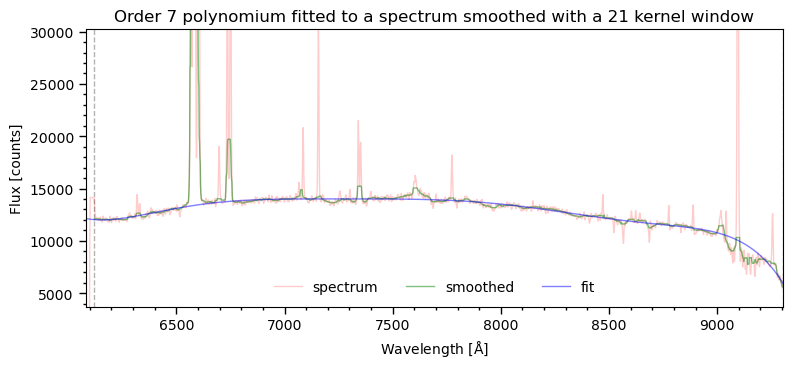

      Fibre 608 does not need to be corrected for negative sky ...
  Corrected 30 fibres for negative sky, 3.04% of fibres.
> Combining 6 brightest lines to obtain object spectrum...
> Detecting emission lines in this spectrum...
  Peak of emission is at 6583.4420199406395, this should be Ha
  Using line Ha, l_rest = 6562.82, peak at l_obs = 6583.44. 
  v_rad = 942.02 km/s, redshift z = 0.00314225


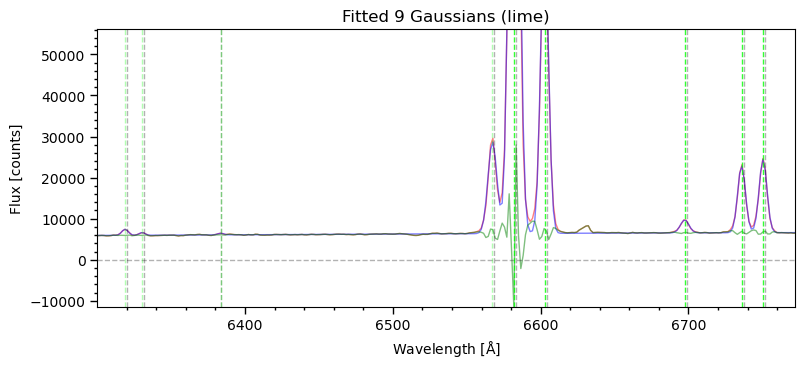

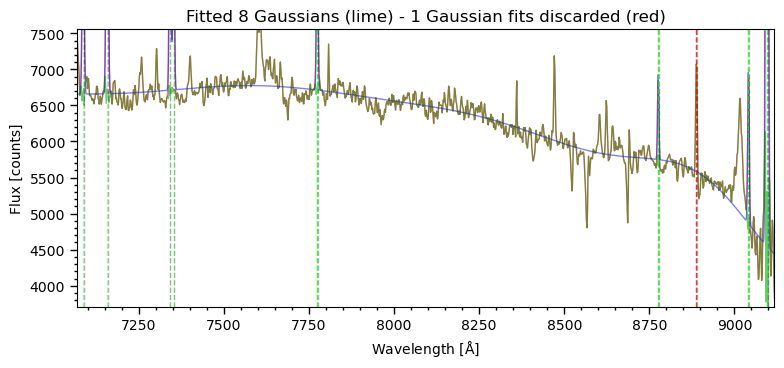

  Identified 17 emission line in this spectrum, with redshift = 0.002947 :
-------------------------------------------------------------------------
   line     ion       fl    Gauss center     peak     sigma         z
-------------------------------------------------------------------------
  6300.30  [OI]     -0.263     6318.84     1479.43    2.177     0.002943
  6312.10  [SIII]   -0.264     6330.38      655.41    1.932     0.002896
  6363.78  [OI]     -0.271     6383.57      385.06    2.175     0.003110
  6548.03  [NII]    -0.296     6567.40    22335.90    3.058     0.002959
  6562.82  Ha       -0.298     6582.16   191578.25    3.040     0.002947
  6583.41  [NII]    -0.300     6602.66    73405.07    2.630     0.002924
  6678.15  HeI      -0.313     6697.46     3156.89    2.916     0.002892
  6716.47  [SII]    -0.318     6735.95    16335.00    2.622     0.002901
  6730.85  [SII]    -0.320     6750.47    17877.06    2.640     0.002915
  7065.28  HeI      -0.364     7085.89     3465.11

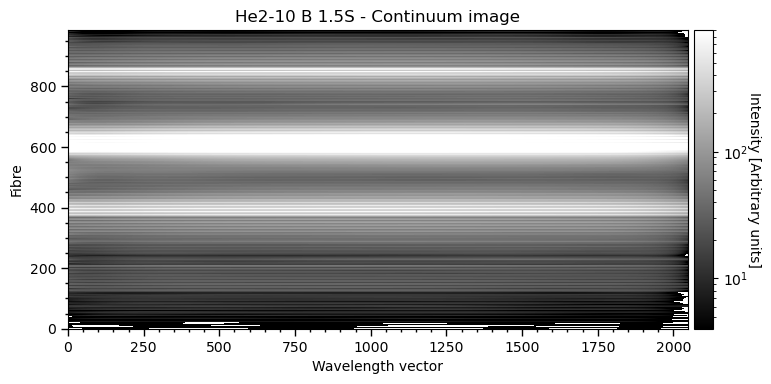

> Cleaning the residuals of this rss in the interval [7590, 7640]
  checking Gaussian fits in fibres with min_value_per_wave_for_fitting > 50 ...
  Checking fibres completed!



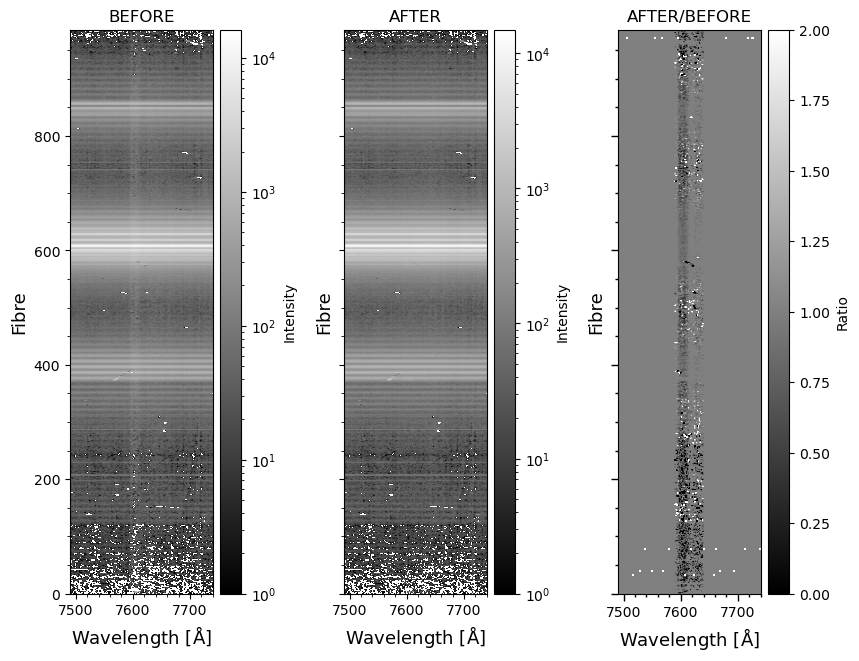


> Correcting the extreme negatives in all fibres, making any pixel below
  np.nanpercentile(intensity_corrected,  0.05 ) =  -125.74
  to have the median value of the fibre...
  Checking fibres completed!



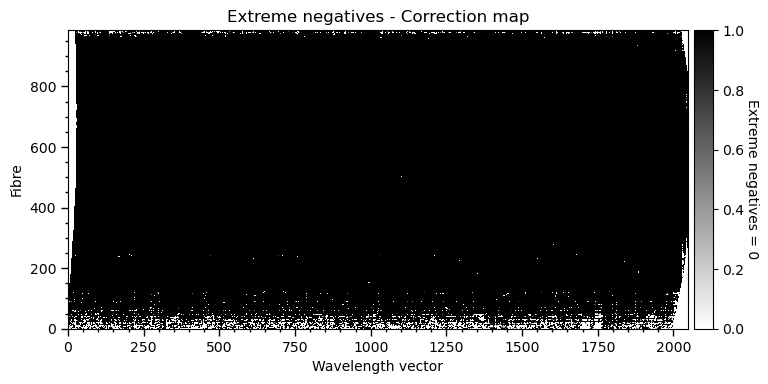


> Finding and killing cosmics in all fibres...
  Checking spectra completed!


  Total number of cosmic candidates found = 13999, correcting only if < 15 per wavelength ...


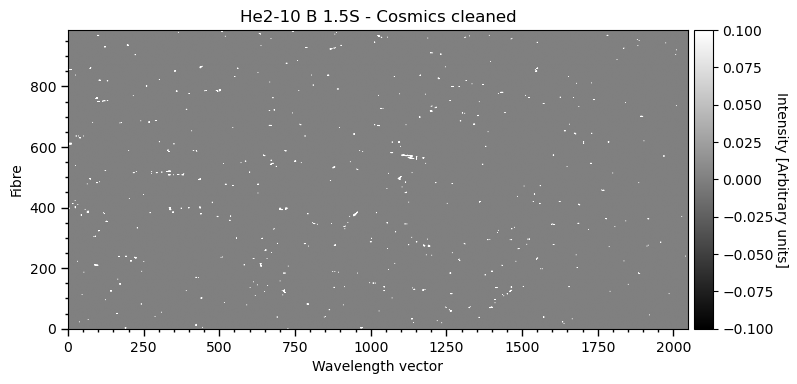

  Total number of cosmics cleaned =  1363
> Mask included in rss applied to make nan all bad pixels in edges.


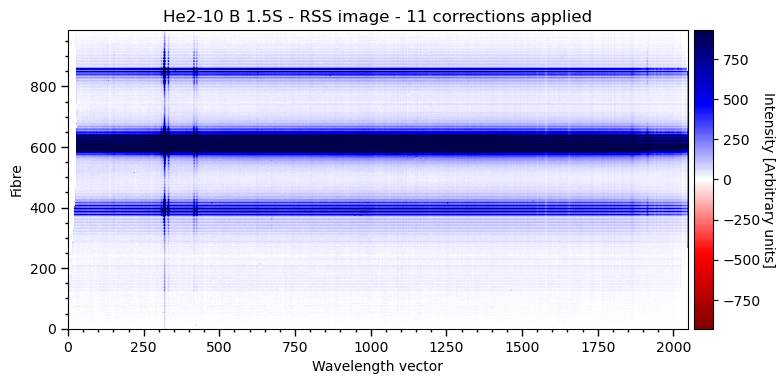


> Summary of processing rss file "27feb20032red.fits" :
  Name of the observation = "He2-10 B 1.5S",   Name of this Python RSS object = "run32_red".
  Corrections applied: 11 in total:
  - apply_throughput
  - correct_ccd_defects
  - wavelength_shift_correction
  - extinction_correction
  - telluric_correction
  - sky_correction
  - negative_sky_correction
  - emission_line_identification
  - big_telluric_residua_correction
  - correct_extreme_negatives
  - clean_cosmics

  All applied corrections are stored in run32_red.intensity !
> Using rss.intensity of given RSS file to create fits file...
  RSS data saved to file "/DATA/KOALA/Jacinda/pablo_data/385R/27feb20032red_clean.fits"


In [41]:
# Set obs_number to be read
obs_number = 32 #31-36  galaxy He2-10

# Set variable "filename" just with the info of the file (it does not include the path in this example)
filename = f"{date}{aaomega_arms[arm]}00{obs_number}red.fits"     

run32_red=process_koala_rss(rss_object_name = "run32_red",                        # Name of the object to be created
                            filename = filename,                                  # name of the .fits file to use
                            path = path_to_filename,                              # path to fits file
                            save_rss_to_fits_file = "clean",                      # Save fits file adding "clean" at the end
                            calibration_night = calibration_night_385R,           # Object with the calibration of the night   
                            
                            apply_throughput = True,                              # (T)  
                            #throughput=throughput_2D_red,                        # Throughput object, included in calibration_night_385R
                            correct_ccd_defects = True,                           # (C)
                            fix_wavelengths = True,                               # (W)
                            #wavelength_shift_correction = wavelength_shift_correction,  # wavelength shift correction object, included in calibration_night_385R 
                            correct_for_extinction = True,                        # (X)
                            apply_telluric_correction = True,                     # (U)
                            #telluric_correction = telluric_correction,           # Telluric correction object, included in calibration_night_385R
 
                            sky_method = "selffit",                                         # (S) Using the same rss and fitting Gaussians to skylines in each fibre
                            n_sky = 25,                                                     # Using the 25 fibres with lowest intensity...          
                            sky_wave_min = 6960,                                            # ... between 6960 ..
                            sky_wave_max = 7220,                                            # ... and 7220
                            bright_emission_lines_to_substract_in_sky = [6584],             # List with bright emission lines to substract in sky, typically H-alpha
                            list_of_skylines_to_fit_near_bright_emission_lines = [[6577]],  # List with lists of adjacent skylines we have to consider close to bright emission lines
                            fix_edges = True,                                               # Use information in the rss to fix the red/blue edges in sky spectrum if needed
 
                            correct_negative_sky = True,                  # (N) Check fibres for negative sky
                            id_el = True,                                 # (E) Identify emission lines in combined spectrum of rss
                            big_telluric_residua_correction = True,       # (R) # Fix residua of the big telluric absorption at ~7600 A 
                            correct_extreme_negatives = True,             # (R) Correct for extreme negatives
                            percentile_min_for_extreme_negatives = 0.05,  # Percentile below which extreme negative will be corrected
                            clean_cosmics = True,                         # (R) Clean cosmics
                            max_number_of_cosmics_per_fibre = 15,         # Max number of cosmics to clean per fibre or wavelength, if more than this it does not correct anything.
                            only_plot_cosmics_cleaned = True,             # The only plot that this task will provide, default is False, but use True for minimizing plotting
                              
                            verbose_counter = False,                                                # Counter does not work on Jypiter
                            plot_final_rss = True, warnings = False, plot = True, verbose = True    # This plots and verbose everything
                            #plot_final_rss = False, warnings=False, plot = False, verbose = False  # This does not plot or verbose (default)
                            )